# <span style="color:blue">Personal Loan Campaign</span>


### Background and Context
AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.


### Objective

1. To predict whether a liability customer will buy a personal loan or not.
2. Which variables are most significant.
3. Which segment of customers should be targeted more.

### Data Dictionary
LABELS | DESCRIPTION
-------|:------------
ID | Customer ID
Age | Customer’s age in completed years
Experience | #years of professional experience
Income | Annual income of the customer (in thousand dollars)
ZIP Code | Home Address ZIP code.
Family | the Family size of the customer
CCAvg | Average spending on credit cards per month (in thousand dollars)
Education | Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
Mortgage | Value of house mortgage if any. (in thousand dollars)
Personal_Loan | Did this customer accept the personal loan offered in the last campaign?
Securities_Account | Does the customer have securities account with the bank?
CD_Account | Does the customer have a certificate of deposit (CD) account with the bank?
Online | Do customers use internet banking facilities?
CreditCard | Does the customer use a credit card issued by any other Bank (excluding All life Bank)?

## <span style="color:blue">Import libraries and load dataset</span>


In [1]:
# installing Zipcodes library
!pip install zipcodes

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
import zipcodes as zcode # to get zipcodes

from sklearn import metrics, tree
#AUC ROC curve
import statsmodels.api as sm

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.tree import DecisionTreeClassifier #for building the model
from sklearn.linear_model import LogisticRegression #for building the model


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, 
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.metrics import plot_confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor



import warnings

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth',400)
pd.set_option('display.float_format', lambda x: '%.5f' % x) 
# To supress numerical display in scientific notations
 # To set the background for the graphs
plt.style.use('ggplot')

warnings.filterwarnings("ignore") #To ignore warnings

%matplotlib inline
sns.set()

### Reading Dataset

**NOTE: I purely used jupyter notebook to load, read and carry out all the working in this dataset**

In [3]:
data = pd.read_csv("Loan_Modelling.csv")
df = data.copy()
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in this dataset.")

There are 5000 rows and 14 columns in this dataset.


## <span>Exporing the Dataset</span>


In [4]:
pd.concat([df.head(5), df.tail(5)])

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.60000,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.50000,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.00000,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.70000,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.00000,2,0,0,0,0,0,1
4995,4996,29,3,40,92697,1,1.90000,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.40000,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.30000,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.50000,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.80000,1,0,0,0,0,1,1


In [5]:
# getting the size of the dataset
df.shape

(5000, 14)

In [6]:
# the columns in the dataset
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal_Loan', 'Securities_Account',
       'CD_Account', 'Online', 'CreditCard'],
      dtype='object')

In [7]:
 # unique values count
df.nunique() 

ID                    5000
Age                     45
Experience              47
Income                 162
ZIPCode                467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Personal_Loan            2
Securities_Account       2
CD_Account               2
Online                   2
CreditCard               2
dtype: int64

In [8]:
#querying for missing values 
df.isnull().values.any() 

False

In [9]:
numerical_feature_df = df.select_dtypes(include=['float64','int64'])
numerical_feature_df.skew()

ID                    0.00000
Age                  -0.02934
Experience           -0.02632
Income                0.84134
ZIPCode              -0.29617
Family                0.15522
CCAvg                 1.59844
Education             0.22709
Mortgage              2.10400
Personal_Loan         2.74361
Securities_Account    2.58827
CD_Account            3.69171
Online               -0.39479
CreditCard            0.90459
dtype: float64

In [10]:
# Querying for info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [11]:
# dropping id coulmn since its not so important here
df.drop(['ID'],axis=1,inplace=True) 

**Observations**
- No missing values.
- All columns being numerical.
- Personal loan is target variable. Zipcode,Family,Education,Securities Account,CD_account,online,Credit card are all categorical variables.

#  Performing Exploratory Data Analysis

#### Processing Zipcode

- we need to analyse if there is any pattern as far as location is concern on the customers who have ever borrowed loan in the previous loan campaign since it can be a good predictor of the target variable

In [12]:
# get unique zipcodes
list_zipcode=df.ZIPCode.unique()

#here i am creating a dictionary of county by using library zipcode and matching method.
dict_zip={}
for zipcode in list_zipcode:
    my_city_county = zcode.matching(zipcode.astype('str'))
    if len(my_city_county)==1: # if  zipcode is present then get county else, assign zipcode to county
        county=my_city_county[0].get('county')
    else:
        county=zipcode
    
    dict_zip.update({zipcode:county})
      

In [13]:
dict_zip

{91107: 'Los Angeles County',
 90089: 'Los Angeles County',
 94720: 'Alameda County',
 94112: 'San Francisco County',
 91330: 'Los Angeles County',
 92121: 'San Diego County',
 91711: 'Los Angeles County',
 93943: 'Monterey County',
 93023: 'Ventura County',
 94710: 'Alameda County',
 90277: 'Los Angeles County',
 93106: 'Santa Barbara County',
 94920: 'Marin County',
 91741: 'Los Angeles County',
 95054: 'Santa Clara County',
 95010: 'Santa Cruz County',
 94305: 'Santa Clara County',
 91604: 'Los Angeles County',
 94015: 'San Mateo County',
 90095: 'Los Angeles County',
 91320: 'Ventura County',
 95521: 'Humboldt County',
 95064: 'Santa Cruz County',
 90064: 'Los Angeles County',
 94539: 'Alameda County',
 94104: 'San Francisco County',
 94117: 'San Francisco County',
 94801: 'Contra Costa County',
 94035: 'Santa Clara County',
 92647: 'Orange County',
 95814: 'Sacramento County',
 94114: 'San Francisco County',
 94115: 'San Francisco County',
 92672: 'Orange County',
 94122: 'San Fra

- county for 92634,92717,93077,96651,93077 since not to exit so i will fix it mutually be searching the internet. 

In [14]:
dict_zip.update({92717:'Orange County'})
dict_zip.update({92634:'Orange County'})

In [15]:
df['County']=df['ZIPCode'].map(dict_zip)

### Fixing the data types
- since most of our variables are of int datatype, changing them to cateory type would reduce on the dataspace required, 

In [16]:
df.columns

Index(['Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal_Loan', 'Securities_Account',
       'CD_Account', 'Online', 'CreditCard', 'County'],
      dtype='object')

In [17]:
# converting categorical varaible to category type
category_columns = ['ZIPCode', 'Family', 'Education', 'Personal_Loan', 'Securities_Account','CD_Account', 'Online', 'CreditCard','County']
df[category_columns] = df[category_columns].astype('category')
    

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   ZIPCode             5000 non-null   category
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   category
 7   Mortgage            5000 non-null   int64   
 8   Personal_Loan       5000 non-null   category
 9   Securities_Account  5000 non-null   category
 10  CD_Account          5000 non-null   category
 11  Online              5000 non-null   category
 12  CreditCard          5000 non-null   category
 13  County              5000 non-null   category
dtypes: category(9), float64(1), int64(4)
memory usage: 266.4 KB


 - As seen, memory usage has decreased  from 547.0 KB to 266.4 KB

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.00000,45.33840,11.46317,23.00000,35.00000,45.00000,55.00000,67.00000
Experience,5000.00000,20.10460,11.46795,-3.00000,10.00000,20.00000,30.00000,43.00000
Income,5000.00000,73.77420,46.03373,8.00000,39.00000,64.00000,98.00000,224.00000
CCAvg,5000.00000,1.93794,1.74766,0.00000,0.70000,1.50000,2.50000,10.00000
Mortgage,5000.00000,56.49880,101.71380,0.00000,0.00000,0.00000,101.00000,635.00000


**Observations**
- Age range from 23 - 67, with mean of 45.
- Maximum experience is 43years. with a mean 20.
- Income range from 8k to 224k USD. with a Mean of 73k USD and median of 64k USD.
- Average spending on credit card per month  ranges from 0- 10k with mean of 1.9kUSD 
- Maximum mortgage taken is 635k USD

In [20]:
df['Personal_Loan'].value_counts()

0    4520
1     480
Name: Personal_Loan, dtype: int64

- 480 customers borrowed loan before.

In [21]:
df['County'].value_counts().head()

Los Angeles County    1095
San Diego County       568
Santa Clara County     563
Alameda County         500
Orange County          366
Name: County, dtype: int64

- Majority of the customers are from Los Angeles with 1095, followed by San Diego, Santa Clara and the rest


### Processing Experience


In [22]:
df[df['Experience']<0].sort_values(by='Experience',ascending=True)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,County
4514,24,-3,41,91768,4,1.00000,3,0,0,0,0,1,0,Los Angeles County
2618,23,-3,55,92704,3,2.40000,2,145,0,0,0,1,0,Orange County
4285,23,-3,149,93555,2,7.20000,1,0,0,0,0,1,0,Kern County
3626,24,-3,28,90089,4,1.00000,3,0,0,0,0,0,0,Los Angeles County
2717,23,-2,45,95422,4,0.60000,2,0,0,0,0,1,1,Lake County
2876,24,-2,80,91107,2,1.60000,3,238,0,0,0,0,0,Los Angeles County
3130,23,-2,82,92152,2,1.80000,2,0,0,1,0,0,1,San Diego County
2466,24,-2,80,94105,2,1.60000,3,0,0,0,0,1,0,San Francisco County
3796,24,-2,50,94920,3,2.40000,2,0,0,1,0,0,0,Marin County
2962,23,-2,81,91711,2,1.80000,2,0,0,0,0,0,0,Los Angeles County


In [23]:
df.groupby(['Age','Education'])['Experience'].describe().T

Age             23                24                         25           \
Education        1        2        1        2        3        1        2   
count      7.00000  5.00000 13.00000  8.00000  7.00000 23.00000 11.00000   
mean      -1.28571 -2.20000 -0.69231 -0.87500 -2.00000  0.52174 -0.27273   
std        0.75593  0.44721  0.94733  0.64087  1.00000  0.79026  0.64667   
min       -3.00000 -3.00000 -2.00000 -2.00000 -3.00000 -1.00000 -1.00000   
25%       -1.00000 -2.00000 -2.00000 -1.00000 -2.50000  0.00000 -1.00000   
50%       -1.00000 -2.00000  0.00000 -1.00000 -2.00000  1.00000  0.00000   
75%       -1.00000 -2.00000  0.00000 -0.75000 -2.00000  1.00000  0.00000   
max       -1.00000 -2.00000  0.00000  0.00000  0.00000  1.00000  1.00000   

Age                      26           ...       64       65                    \
Education        3        1        2  ...        3        1        2        3   
count     19.00000 30.00000 24.00000  ... 30.00000 30.00000 23.00000 27.00000   
mean      -0.52632  1.43333  0.75000  ... 38.53333 39.86667 40.08696 39.51852   
std        0.69669  0.81720  0.84699  ...  1.75643  0.73030  0.73318  1.55342   
min       -2.00000  0.00000 -1.00000  ... 34.00000 39.00000 39.00000 35.00000   
25%       -1.00000  1.00000  0.00000  ... 38.00000 39.00000 40.00000 39.00000   
50%       -1.00000  2.00000  1.00000  ... 39.00000 40.00000 40.00000 40.00000   
75%        0.00000  2.00000  1.00000  ... 40.00000 40.00000 41.00000 41.00000   
max        1.00000  2.00000  2.00000  ... 40.00000 41.00000 41.00000 41.00000   

Age             66                         67                    
Education        1        2        3        1        2        3  
count      9.00000  5.00000 10.00000  5.00000  3.00000  4.00000  
mean      41.11111 41.40000 40.40000 41.60000 42.66667 41.50000  
std        0.33333  0.54772  1.64655  0.89443  0.57735  0.57735  
min       41.00000 41.00000 36.00000 41.00000 42.00000 41.00000  
25%       41.00000 41.00000 40.25000 41.00000 42.50000 41.00000  
50%       41.00000 41.00000 41.00000 41.00000 43.00000 41.50000  
75%       41.00000 42.00000 41.00000 42.00000 43.00000 42.00000  
max       42.00000 42.00000 42.00000 43.00000 43.00000 42.00000  

[8 rows x 134 columns]

- Experience seem to be negative for all observation with for age 23,24, and few others . Based on there age and education these negatives could be by mistake. so changing them to absoulte values of experience will be of help

In [24]:
df.loc[df['Experience']<0,'Experience']=np.abs(df['Experience'])

In [25]:
df[df['Experience']==0]['Age'].describe()

count   66.00000
mean    25.63636
std      1.14538
min     24.00000
25%     25.00000
50%     26.00000
75%     26.00000
max     30.00000
Name: Age, dtype: float64

- Checking age and income for customers with 0 experience.

### Univariate Analysis

In [26]:
def dist_box(data):
 # function plots a combined graph for univariate analysis of continous variable 
 #to check spread, central tendency , dispersion and outliers  
    Name=data.name.upper()
    fig,(ax_box,ax_dis)  =plt.subplots(nrows=2,sharex=True,gridspec_kw = {"height_ratios": (.25, .75)},figsize=(8, 5))
    mean=data.mean()
    median=data.median()
    mode=data.mode().tolist()[0]
    sns.set_theme(style="white")
    fig.suptitle("SPREAD OF DATA FOR "+ Name  , fontsize=18, fontweight='bold')
    sns.boxplot(x=data,showmeans=True, orient='h',color="violet",ax=ax_box)
    ax_box.set(xlabel='')
     # just trying to make visualisation better. This will set background to white
    sns.despine(top=True,right=True,left=True) # to remove side line from graph
    sns.distplot(data,kde=False,color='blue',ax=ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-',linewidth=2)
    ax_dis.axvline(mode, color='y', linestyle='-',linewidth=2)
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})
                    

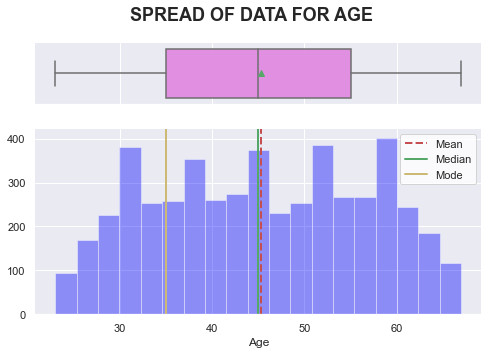

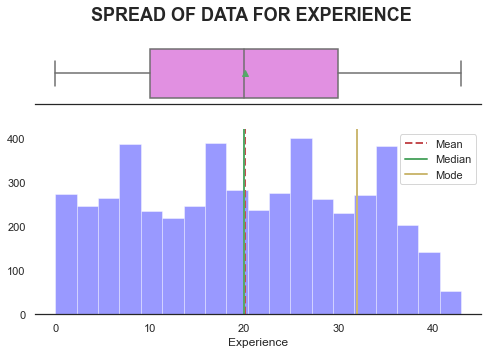

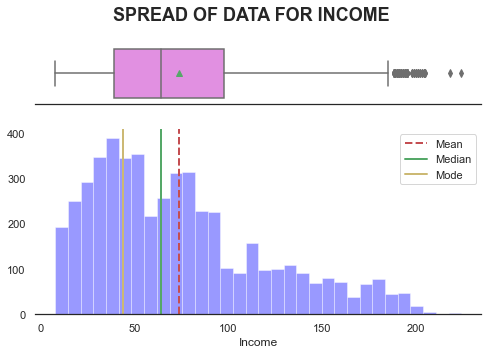

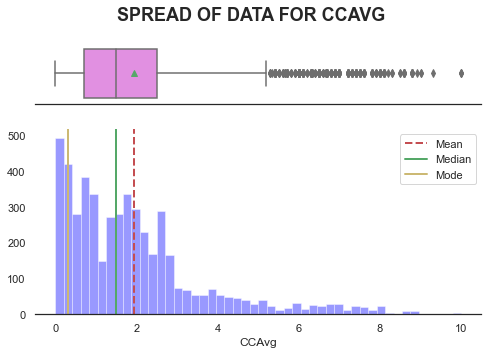

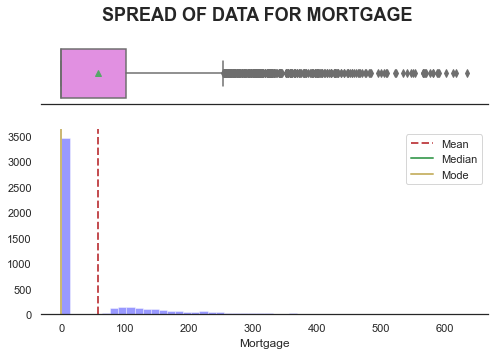

In [27]:
#select all quantitative columns for checking the spread
list_column=  ["Age","Experience","Income","CCAvg","Mortgage"]
for i in range(len(list_column)):
    dist_box(df[list_column[i]])

**Observations**
- Age and experience both has same distrubtion with spike at 5 points.
- Income is right skewed and has some outlier on higher side which can be clipped.
- Average montly credit is right skewed and has lot of outliers on higher side which can be clipped.
- Mortgage is  mostly 0 . but is  right skewed and has lot of outlier on higher side which can be clipped.


### Age
Age can be a vital factor in borrowing loan, converting ages to bin to explore if there is any pattern 

In [28]:
df['Agebin'] = pd.cut(df['Age'], bins = [0, 30, 40, 50, 60, 100], labels = ['18-30', '31-40', '41-50', '51-60', '60-100'])

### Income
To understand customers segments derving new columns which will help us identify if customer belongs to Upper , middle or lower income group 

In [29]:
# Create a new variable - Income group

df["Income_group"] = pd.cut(
    x=df["Income"],
    bins=[0, 50, 140, 224],
    labels=["Lower", "Middle", "High"],
)

### Spending
To understand customers spending derving new columns which will say if customer belongs to Upper , middle or lower spending

In [30]:
df.CCAvg.describe()

count   5000.00000
mean       1.93794
std        1.74766
min        0.00000
25%        0.70000
50%        1.50000
75%        2.50000
max       10.00000
Name: CCAvg, dtype: float64

In [31]:
df["Spending"] = pd.cut( x=df["CCAvg"], bins=[0.00000, 0.70000, 2.50000, 10.00000],
    labels=["Low", "Medium", "High"],include_lowest=True ,
)


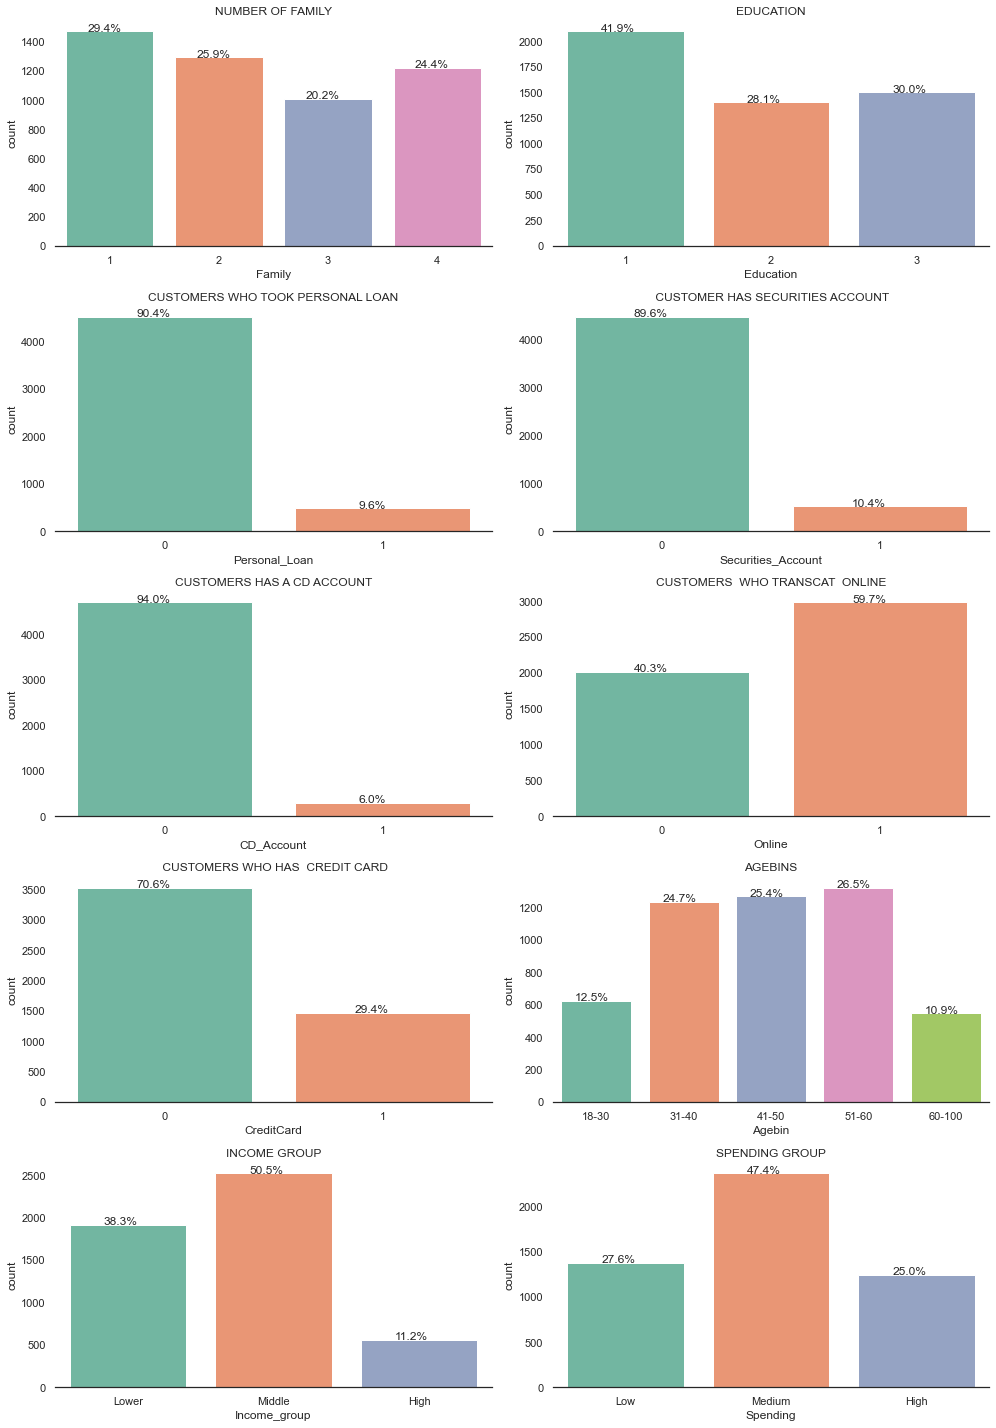

In [32]:
# Making a list of all categorical variables
cat_columns = ['Family','Education','Personal_Loan','Securities_Account',
               'CD_Account','Online','CreditCard','Agebin','Income_group','Spending']
title=['Number of Family','Education','Customers who took Personal Loan',
       ' Customer has Securities Account','Customers has a CD Account',
       'Customers  who transcat  Online',' Customers who has  Credit Card','Agebins',"Income group",'Spending group']
plt.figure(figsize=(14,20))

sns.set_theme(style="white") # just trying to make visualisation better. This will set background to white
#list_palette=['Blues_r','Greens_r','Purples_r','Reds_r','Blues_r','Greens_r','Purples_r','Reds_r','Blues_r']

for i, variable in enumerate(cat_columns):
                     plt.subplot(5,2,i+1)
                     order = df[variable].value_counts(ascending=False).index   
                     #sns.set_palette(list_palette[i]) # to set the palette
                     sns.set_palette('Set2')
                     ax=sns.countplot(x=df[variable], data=df )
                     sns.despine(top=True,right=True,left=True) # to remove side line from graph
                     for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(df[variable]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')
                     plt.tight_layout()
                     plt.title(title[i].upper())
                                     


**Observations**
- Less than 29.4 % customers are single.
- 41.9% customers are undergrade.
- 9.6% borrowed personal loan from the bank.
- 10.4 %  customers have a securities account with the bank
- 6 % customer have a CD account.
- 59.7 % customers  transact online.
- 29.4 % customers have  credit cards.  
- about 76.6%of customers  are in range of 31- 60yrs.
- 50.5 % of bank customers belong to middle income group.
- Less than 48 % of customers have medium Average spending

In [33]:
df.groupby(['County','Personal_Loan'])['Personal_Loan'].agg({'size'}).unstack()



size     
Personal_Loan             0    1
County                          
93077                     1    0
96651                     6    0
Alameda County          456   44
Butte County             17    2
Contra Costa County      73   12
El Dorado County         16    1
Fresno County            24    2
Humboldt County          30    2
Imperial County           3    0
Kern County              47    7
Lake County               4    0
Los Angeles County      984  111
Marin County             48    6
Mendocino County          7    1
Merced County             4    0
Monterey County         113   15
Napa County               3    0
Orange County           333   33
Placer County            22    2
Riverside County         50    6
Sacramento County       169   15
San Benito County        14    0
San Bernardino County    98    3
San Diego County        509   59
San Francisco County    238   19
San Joaquin County       12    1
San Luis Obispo County   28    5
San Mateo County        192   12
Santa Barbara County    143   11
Santa Clara County      492   71
Santa Cruz County        60    8
Shasta County            15    3
Siskiyou County           7    0
Solano County            30    3
Sonoma County            22    6
Stanislaus County        14    1
Trinity County            4    0
Tuolumne County           7    0
Ventura County          103   11
Yolo County             122    8

<AxesSubplot:ylabel='County'>

<Figure size 1224x1872 with 0 Axes>

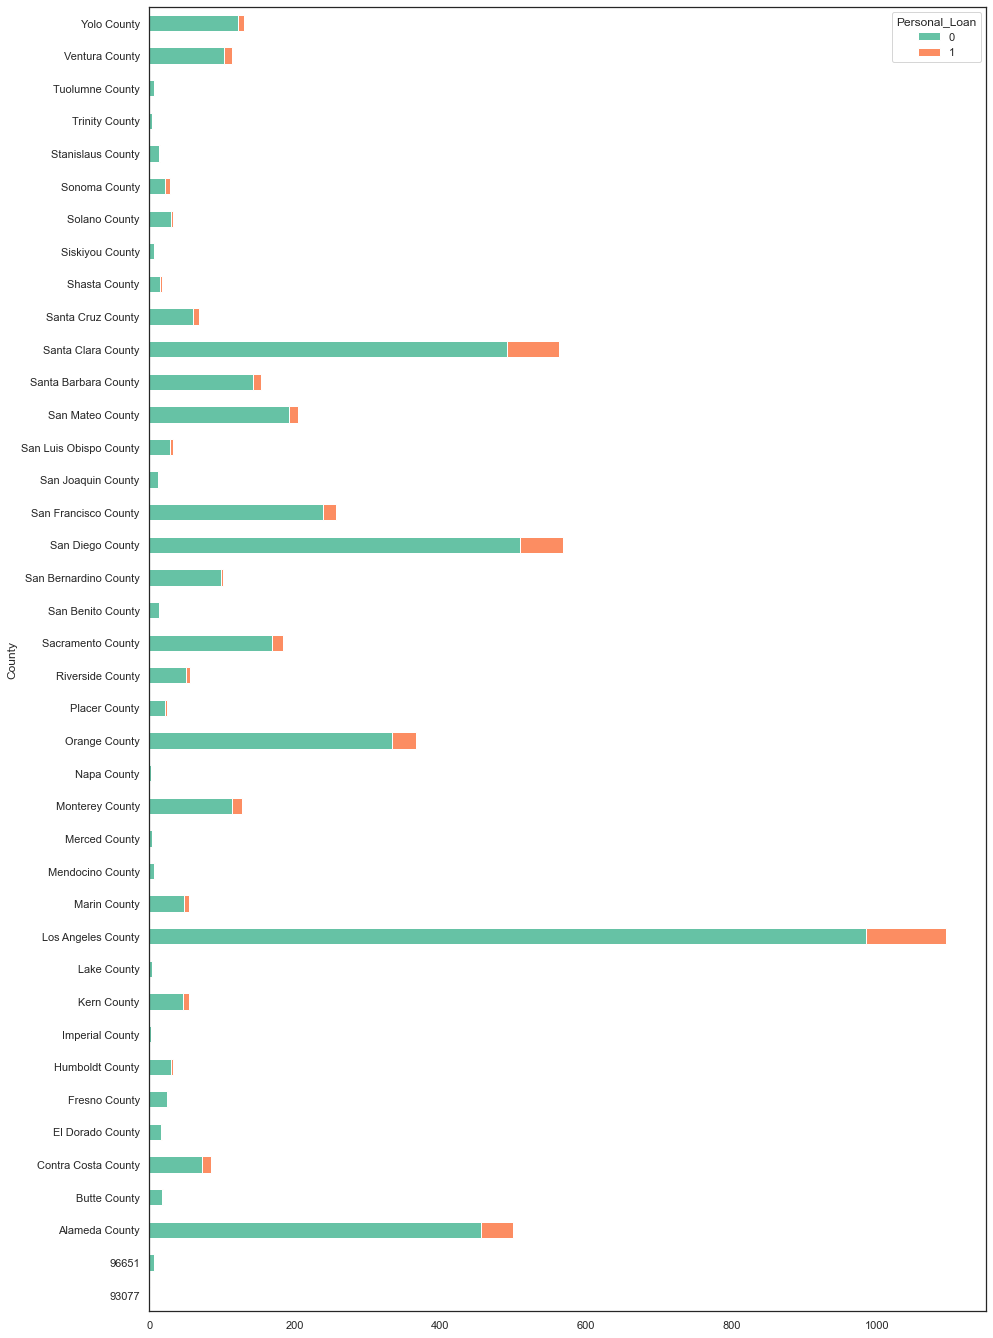

In [34]:
plt.figure(figsize=(17,26))

pd.crosstab(index=df['County'],columns=df['Personal_Loan'].sort_values(ascending=False)).plot(kind='barh',stacked=True,figsize=(15,24))

- It can be seen the percentage of loan taken from various country differ.There are so many county converting them to regions will help in our model

In [35]:
counties = {
'Los Angeles County':'Los Angeles Region',
'San Diego County':'Southern',
'Santa Clara County':'Bay Area',
'Alameda County':'Bay Area',
'Orange County':'Southern',
'San Francisco County':'Bay Area',
'San Mateo County':'Bay Area',
'Sacramento County':'Central',
'Santa Barbara County':'Southern',
'Yolo County':'Central',
'Monterey County':'Bay Area',            
'Ventura County':'Southern',             
'San Bernardino County':'Southern',       
'Contra Costa County':'Bay Area',        
'Santa Cruz County':'Bay Area',           
'Riverside County':'Southern',            
'Kern County':'Southern',                 
'Marin County':'Bay Area',                
'San Luis Obispo County':'Southern',     
'Solano County':'Bay Area',              
'Humboldt County':'Superior',            
'Sonoma County':'Bay Area',                
'Fresno County':'Central',               
'Placer County':'Central',                
'Butte County':'Superior',               
'Shasta County':'Superior',                
'El Dorado County':'Central',             
'Stanislaus County':'Central',            
'San Benito County':'Bay Area',          
'San Joaquin County':'Central',           
'Mendocino County':'Superior',             
'Tuolumne County':'Central',                
'Siskiyou County':'Superior',              
'Trinity County':'Superior',                
'Merced County':'Central',                  
'Lake County':'Superior',                 
'Napa County':'Bay Area',                   
'Imperial County':'Southern',
93077:'Southern',
96651:'Bay Area'
}

**Converting the county to regions based on  https://www.calbhbc.org/region-map-and-listing.html**

In [36]:
df['Regions'] = df['County'].map(counties)

In [37]:
df['Regions'].unique()

array(['Los Angeles Region', 'Bay Area', 'Southern', 'Superior',
       'Central'], dtype=object)

In [38]:
df.isnull().sum()

Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
County                0
Agebin                0
Income_group          0
Spending              0
Regions               0
dtype: int64

In [39]:
df.dropna(inplace=True)

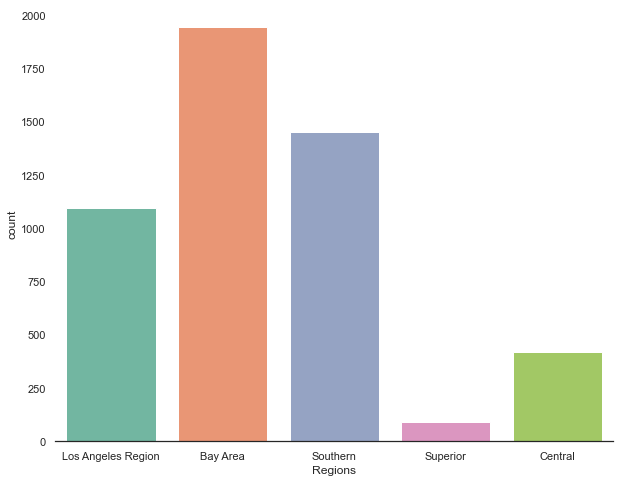

In [40]:
plt.figure(figsize=(10,8))
sns.countplot(data=df,x=df['Regions'])
sns.despine(top=True,right=True,left=True) 

### Bivariate Analysis

In [41]:
## Function to plot stacked bar chart
def stacked_plot(x, y):
    """
    Shows stacked plot from x and y pandas data series
    x: pandas data series
    y: pandas data series
    """
    info = pd.crosstab(x, y, margins=True)
    info['% - 0'] = round(info[0]/info['All']*100, 2)
    info['% - 1'] = round(info[1]/info['All']*100, 2)
    print(info)
    print('='*80)
    visual = pd.crosstab(x, y, normalize='index')
    visual.plot(kind='bar', stacked=True, figsize=(10,5));

In [42]:
def show_boxplots(cols: list, feature: str, show_fliers=True, data=df): #method call to show bloxplots
    n_rows = math.ceil(len(cols)/2)
    plt.figure(figsize=(15, n_rows*5))
    for i, variable in enumerate(cols):
        plt.subplot(n_rows, 2, i+1)
        if show_fliers:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=True) 
        else:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=False)
        plt.tight_layout()
        plt.title(variable, fontsize=12)
    plt.show()

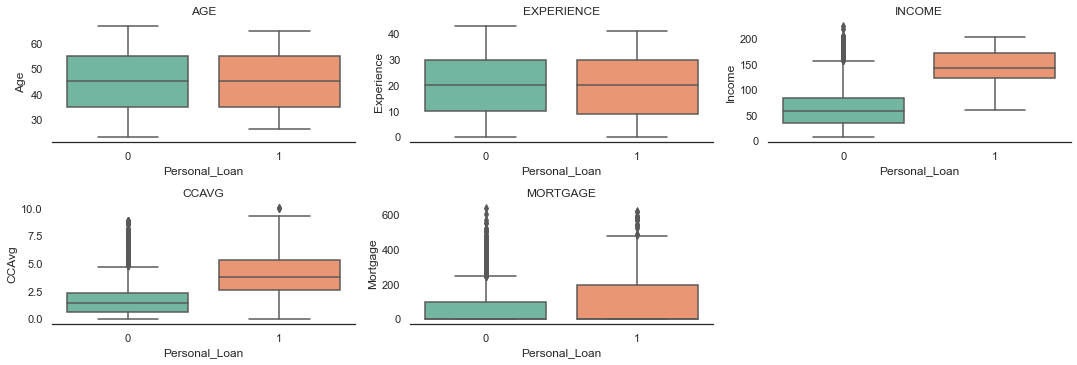

In [43]:
numeric_columns = ['Age','Experience','Income','CCAvg','Mortgage']
plt.figure(figsize=(15,25))

sns.set_palette(sns.color_palette("Set2", 8))
for i, variable in enumerate(numeric_columns):
        plt.subplot(10,3,i+1)
        
        sns.boxplot(x='Personal_Loan',y= df[variable], data=df)     
        sns.despine(top=True,right=True,left=True) 
        plt.tight_layout()
        plt.title(variable.upper())

### Correlation and heatmap


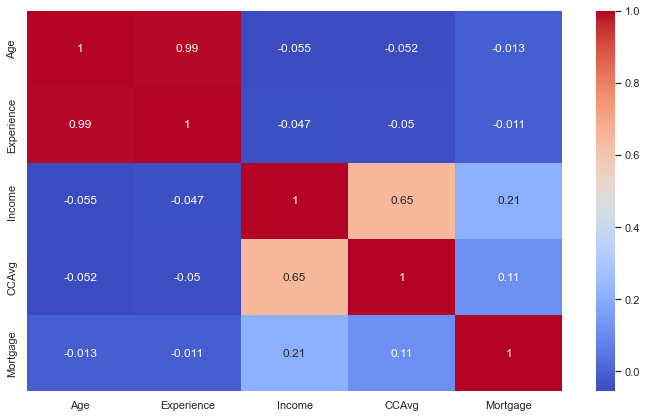

In [44]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm");

**Observations**
- Age and experience are positively correlated heavily.
- ccavg and income are also positively correlated.

In [45]:
df.columns

Index(['Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal_Loan', 'Securities_Account',
       'CD_Account', 'Online', 'CreditCard', 'County', 'Agebin',
       'Income_group', 'Spending', 'Regions'],
      dtype='object')

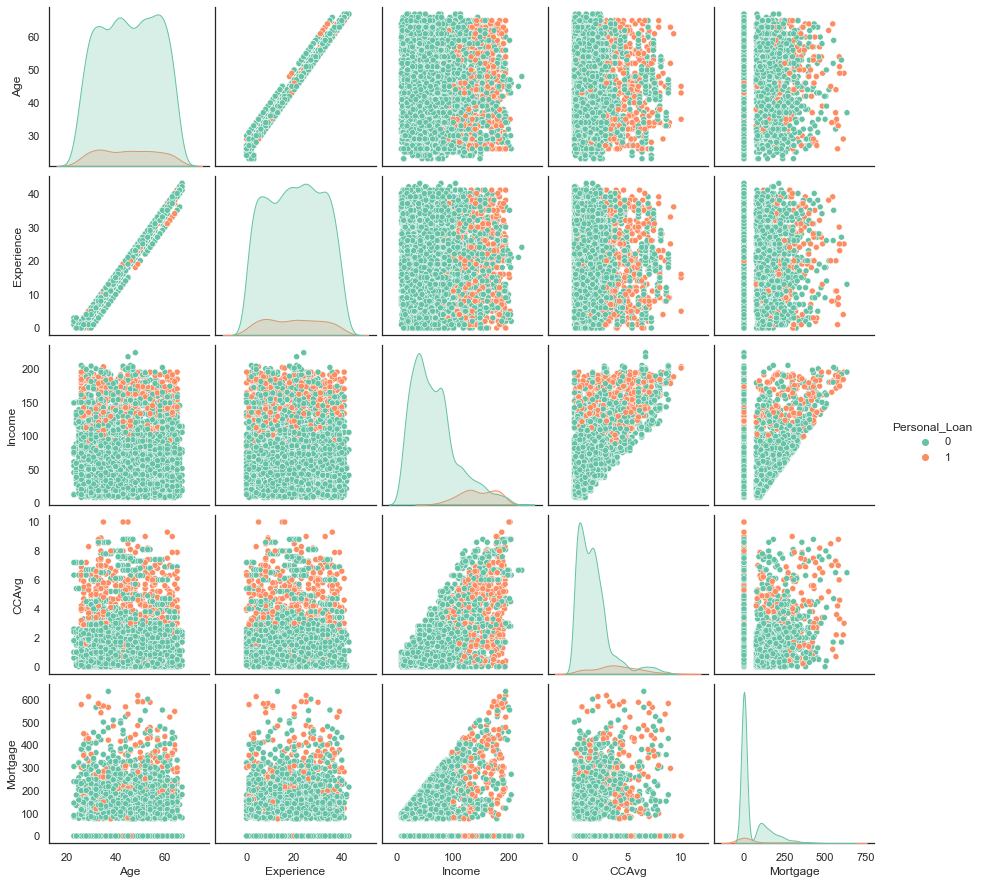

In [46]:
sns.pairplot(data=df[['Age','Experience','Income','ZIPCode','CCAvg',
                      'Mortgage','Personal_Loan']], 
             hue='Personal_Loan');

**Observations**
- Customers with personal_loan have higher income and higher ccavg


### comparing personal_loan with Family, securities_account, cd_account, education, creditcard and online

Personal_Loan     0    1   All    % - 0    % - 1
Family                                          
1              1365  107  1472 92.73000  7.27000
2              1190  106  1296 91.82000  8.18000
3               877  133  1010 86.83000 13.17000
4              1088  134  1222 89.03000 10.97000
All            4520  480  5000 90.40000  9.60000
Personal_Loan          0    1   All    % - 0    % - 1
Securities_Account                                   
0                   4058  420  4478 90.62000  9.38000
1                    462   60   522 88.51000 11.49000
All                 4520  480  5000 90.40000  9.60000
Personal_Loan     0    1   All    % - 0    % - 1
CD_Account                                      
0              4358  340  4698 92.76000  7.24000
1               162  140   302 53.64000 46.36000
All            4520  480  5000 90.40000  9.60000
Personal_Loan     0    1   All    % - 0    % - 1
Education                                       
1              2003   93  2096 95.56000  4.4

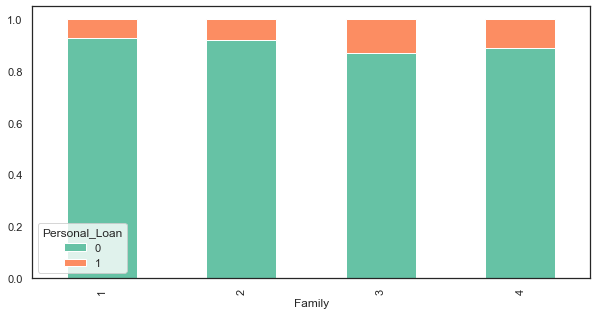

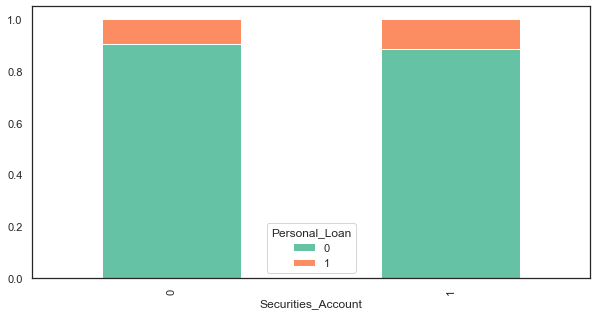

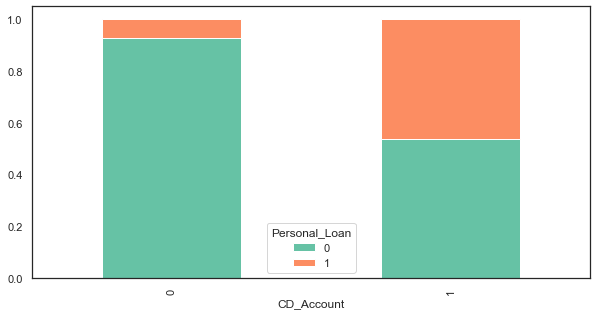

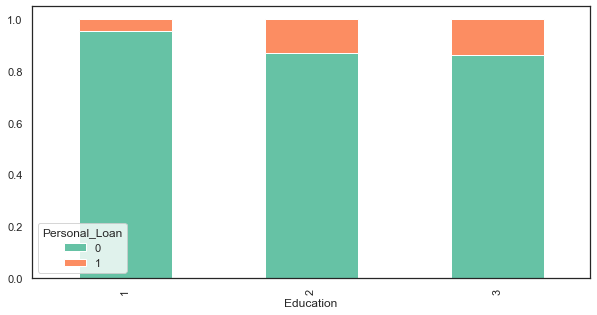

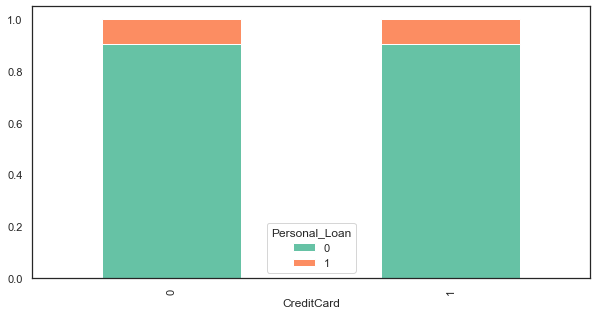

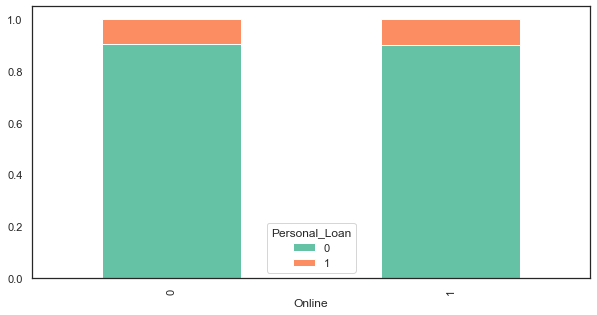

In [47]:
stacked_plot(df.Family, df.Personal_Loan)
stacked_plot(df.Securities_Account, df.Personal_Loan)
stacked_plot(df.CD_Account, df.Personal_Loan)
stacked_plot(df.Education, df.Personal_Loan)
stacked_plot(df.CreditCard, df.Personal_Loan)
stacked_plot(df.Online, df.Personal_Loan)

**Observations** 
- Those customers with a `family` of 4 have more `personal loans`. 
- A family of 3 have the second most personal loans followed by a family of 1 and 2.

- There is not much difference in securities account versus personal loans

- Those customers with cd accounts. have a greater percentage of personal loans than those customer without a cd account. 

- Those customers with an education of '2' and '3' hold a greater percentage of personal loans that those customer with an education of '1'.

- There isn't much difference between those who have credit cards from other banks versus personal loans.

- There isnt much difference between customers who use online facilities and those who don't versus personal loans.

### Comparing cd_account with family,online,securities_account, creditcard and education


CD_Account     0    1   All    % - 0   % - 1
Family                                      
1           1389   83  1472 94.36000 5.64000
2           1229   67  1296 94.83000 5.17000
3            928   82  1010 91.88000 8.12000
4           1152   70  1222 94.27000 5.73000
All         4698  302  5000 93.96000 6.04000
CD_Account     0    1   All    % - 0   % - 1
Online                                      
0           1997   19  2016 99.06000 0.94000
1           2701  283  2984 90.52000 9.48000
All         4698  302  5000 93.96000 6.04000
CD_Account             0    1   All    % - 0    % - 1
Securities_Account                                   
0                   4323  155  4478 96.54000  3.46000
1                    375  147   522 71.84000 28.16000
All                 4698  302  5000 93.96000  6.04000
CD_Account     0    1   All    % - 0    % - 1
CreditCard                                   
0           3468   62  3530 98.24000  1.76000
1           1230  240  1470 83.67000 16.33000
All   

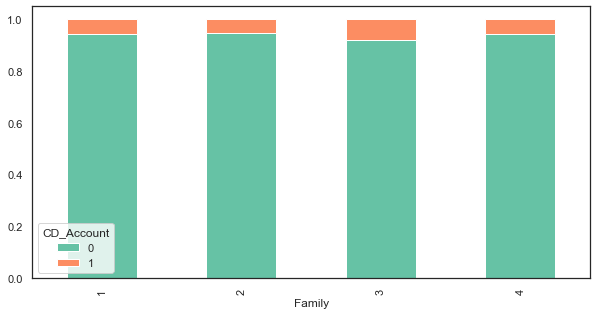

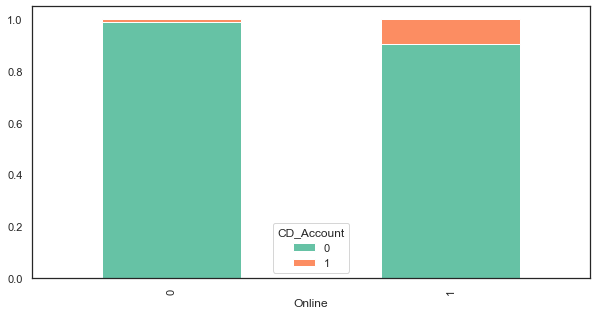

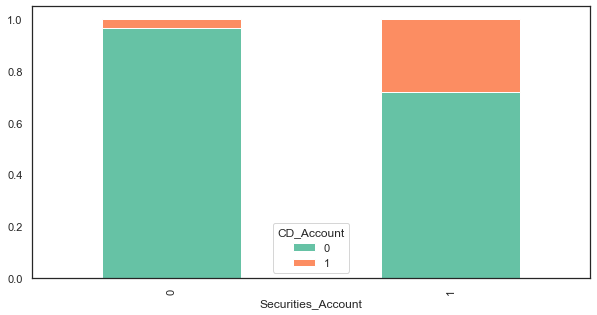

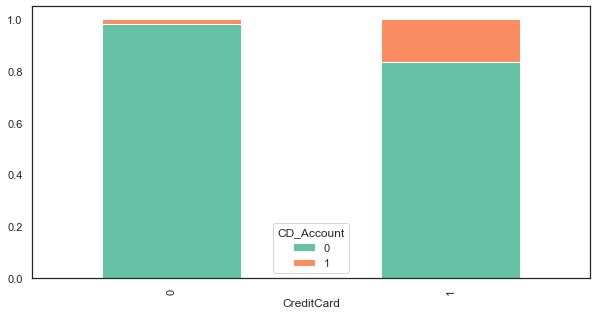

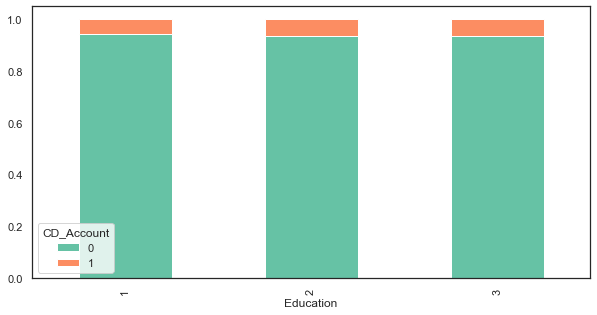

In [48]:
stacked_plot(df.Family, df.CD_Account)
stacked_plot(df.Online, df.CD_Account)
stacked_plot(df.Securities_Account, df.CD_Account)
stacked_plot(df.CreditCard, df.CD_Account)
stacked_plot(df.Education, df.CD_Account)

**Observations**
- A family of 3 has the greatest percentage(8.12) of customers with cd accounts

- Customers who use the online facilities have a greater percentage cd accounts than those customer who don't use online facilities.

- A greater percentage of those customers with security accounts also have cd accounts versus those customer that dont have security accounts.

- A greater percentage of those customers who have credit cards with other bank institutions have personal cd accounts than those customers who dont have credit cards from other institutions.

- There isnt much of a difference between education categories.

###  checking which of these differences are statistically significant.
 we will use Chi-Square test to determine if two categorical variables have a significant correlation between them.
  
**$H_0$:**  There is no association between the two variables.      
**$H_a$:**  There is an association between two variables.

In [49]:
def check_significance(feature1: str, feature2: str, data=df):
    """
    Checks the significance of feature1 agaisnt feature2
    feature1: column name
    feature2: column name
    data: pandas dataframe object (defaults to df)
    """
    crosstab = pd.crosstab(data[feature1], data[feature2])  # Contingency table of region and smoker attributes
    chi, p_value, dof, expected =  stats.chi2_contingency(crosstab)
    Ho = f"{feature1} has no effect on {feature2}"   # Stating the Null Hypothesis
    Ha = f"{feature1} has an effect on {feature2}"   # Stating the Alternate Hypothesis
    if p_value < 0.05:  # Setting our significance level at 5%
        print(f'{Ha.upper()} as the p_value ({p_value.round(3)}) < 0.05')
    else:
        print(f'{Ho} as the p_value ({p_value.round(3)}) > 0.05')

In [50]:
def show_significance(features: list, data=df):
    """
    Prints out the significance of all the list of features passed.
    features: list of column names
    data: pandas dataframe object (defaults to df)
    """
    for feature in features:
        print("="*30, feature, "="*(50-len(feature)))
        for col in list(data.columns):
            if col != feature: check_significance(col , feature)
                
show_significance(['Personal_Loan', 'CD_Account'])

============================== Personal_Loan =====================================
Age has no effect on Personal_Loan as the p_value (0.12) > 0.05
Experience has no effect on Personal_Loan as the p_value (0.805) > 0.05
INCOME HAS AN EFFECT ON PERSONAL_LOAN as the p_value (0.0) < 0.05
ZIPCode has no effect on Personal_Loan as the p_value (0.76) > 0.05
FAMILY HAS AN EFFECT ON PERSONAL_LOAN as the p_value (0.0) < 0.05
CCAVG HAS AN EFFECT ON PERSONAL_LOAN as the p_value (0.0) < 0.05
EDUCATION HAS AN EFFECT ON PERSONAL_LOAN as the p_value (0.0) < 0.05
MORTGAGE HAS AN EFFECT ON PERSONAL_LOAN as the p_value (0.0) < 0.05
Securities_Account has no effect on Personal_Loan as the p_value (0.141) > 0.05
CD_ACCOUNT HAS AN EFFECT ON PERSONAL_LOAN as the p_value (0.0) < 0.05
Online has no effect on Personal_Loan as the p_value (0.693) > 0.05
CreditCard has no effect on Personal_Loan as the p_value (0.884) > 0.05
County has no effect on Personal_Loan as the p_value (0.528) > 0.05
Agebin has no effect 

### Observations - 
* cd_account, family and education seem to be strong indicators that a  customers received a personal loan.
* securities_account, online and credit_card seem to be strong indicators of customers who have cd accounts.
* Other factors appear not very good indicators of those customers that have cd accounts. 

### Check  distrubution in target column


([<matplotlib.patches.Wedge at 0x2902563cf70>,
 [Text(-1.050350983068654, 0.3267457916587637, ''),
  Text(1.0503509677725784, -0.32674584082924163, '')],
 [Text(-0.5729187180374475, 0.17822497726841657, '90.4%'),
  Text(0.5729187096941336, -0.17822500408867725, '9.6%')])

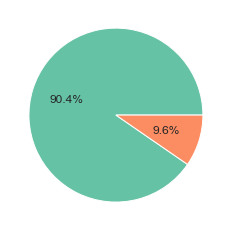

In [51]:
plt.pie(data=df,x=df["Personal_Loan"].value_counts(),autopct='%1.1f%%')

- The target variable personal_loan is highly imbalanced where only 9.6% of the customers have previously opted for a personal loan in the dataset. we can handle this using weight

In [52]:
# Saving dataset before treating outliers for logistic regression.
df_Decision = df.copy()

**Actions for data pre-processing:**

* Many variables have outliers that need to be treated.
* We can drop Experience, Country,Zipcode and Agebin,Income_group,Spending_group.

###  Detecting Outliers 

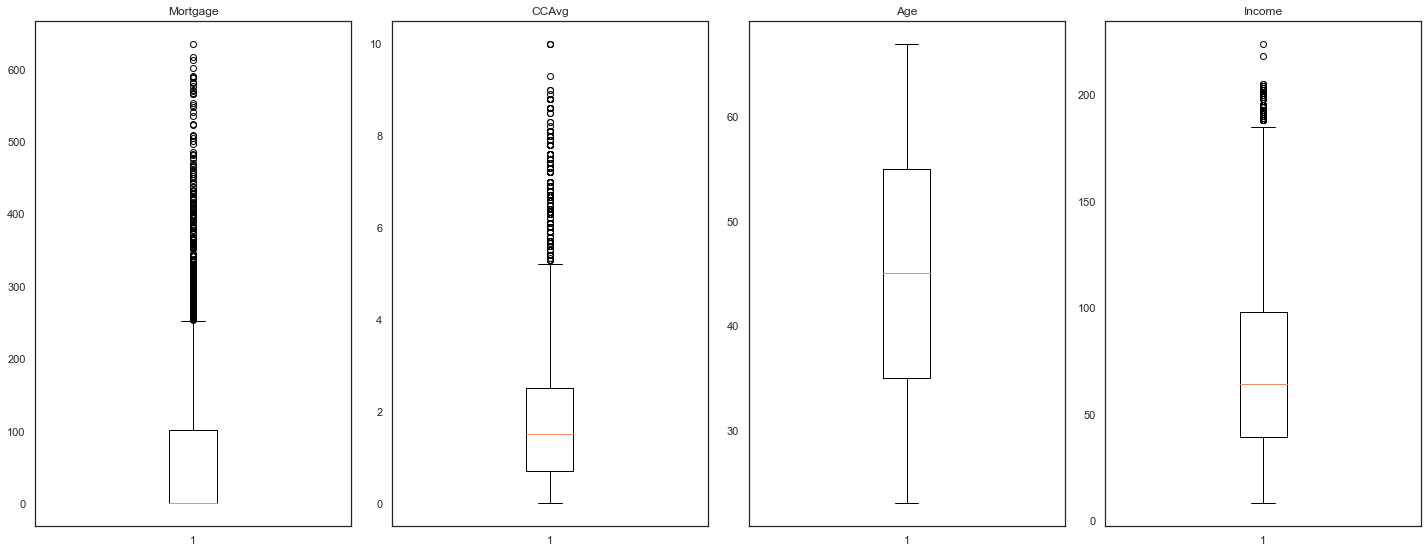

In [53]:
#selecting numeric columns
columns =["Mortgage","CCAvg","Age","Income"]

# detecting outlier using boxplot
plt.figure(figsize=(20,30))

for i, variable in enumerate(columns):
                     plt.subplot(4,4,i+1)
                     plt.boxplot(df[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

In [54]:
# Checking Income extreme values
df.sort_values(by=["Income"],ascending = False).head(5)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,County,Agebin,Income_group,Spending,Regions
3896,48,24,224,93940,2,6.67000,1,0,0,0,1,1,1,Monterey County,41-50,High,High,Bay Area
4993,45,21,218,91801,2,6.67000,1,0,0,0,0,1,0,Los Angeles County,41-50,High,High,Los Angeles Region
526,26,2,205,93106,1,6.33000,1,271,0,0,0,0,1,Santa Barbara County,18-30,High,High,Southern
2988,46,21,205,95762,2,8.80000,1,181,0,1,0,1,0,El Dorado County,41-50,High,High,Central
4225,43,18,204,91902,2,8.80000,1,0,0,0,0,1,0,San Diego County,41-50,High,High,Southern


In [55]:
df.loc[(df['Age']==48) & (df['Experience']==24)].sort_values(by=['Income'],ascending=False).head(5)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,County,Agebin,Income_group,Spending,Regions
3896,48,24,224,93940,2,6.67000,1,0,0,0,1,1,1,Monterey County,41-50,High,High,Bay Area
196,48,24,165,93407,1,5.00000,1,0,0,0,0,0,1,San Luis Obispo County,41-50,High,High,Southern
2217,48,24,162,91355,4,3.30000,2,446,1,0,1,1,0,Los Angeles County,41-50,High,High,Los Angeles Region
4629,48,24,148,91311,2,3.30000,1,0,0,0,1,1,1,Los Angeles County,41-50,High,High,Los Angeles Region
4167,48,24,144,94025,4,3.50000,2,0,1,0,0,0,0,San Mateo County,41-50,High,High,Bay Area


In [56]:
# Checking CCAVg extreme values
df.sort_values(by=["CCAvg"],ascending = False).head(5)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,County,Agebin,Income_group,Spending,Regions
787,45,15,202,91380,3,10.00000,3,0,1,0,0,0,0,Los Angeles County,41-50,High,High,Los Angeles Region
2101,35,5,203,95032,1,10.00000,3,0,1,0,0,0,0,Santa Clara County,31-40,High,High,Bay Area
2337,43,16,201,95054,1,10.00000,2,0,1,0,0,0,1,Santa Clara County,41-50,High,High,Bay Area
3943,61,36,188,91360,1,9.30000,2,0,1,0,0,0,0,Ventura County,60-100,High,High,Southern
3822,63,33,178,91768,4,9.00000,3,0,1,0,0,0,0,Los Angeles County,60-100,High,High,Los Angeles Region


In [57]:
# Checking Mortgage extreme values
df.sort_values(by=["Mortgage"],ascending = False).head(5)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,County,Agebin,Income_group,Spending,Regions
2934,37,13,195,91763,2,6.50000,1,635,0,0,0,1,0,San Bernardino County,31-40,High,High,Southern
303,49,25,195,95605,4,3.00000,1,617,1,0,0,0,0,Yolo County,41-50,High,High,Central
4812,29,4,184,92126,4,2.20000,3,612,1,0,0,1,0,San Diego County,18-30,High,Medium,Southern
1783,53,27,192,94720,1,1.70000,1,601,0,0,0,1,0,Alameda County,51-60,High,Medium,Bay Area
4842,49,23,174,95449,3,4.60000,2,590,1,0,0,0,0,Mendocino County,41-50,High,High,Superior


- There are some really extreme values in income 224K USD compared to same age group and experience. Values for Credit card and Mortages looks fine.After identifying outliers, am not treating the outliers since in real life of loan personal campaign they wil actually exist this will enable the model to study their pattern

In [58]:
# at this point am going to drop some columns that i wouldn't be needing for modeling
df.drop(columns=["ZIPCode", "Agebin","Spending", "County","Experience","Income_group"], inplace=True)

- We have 6 categorical independent variables but 4 of them are binary, i will only make dummies for Regions and Education since the rest will all give thye same result

In [59]:
X = df.drop(["Personal_Loan"], axis=1)
Y = df["Personal_Loan"]

Cols=["Education","Regions"]
X=pd.get_dummies(X,columns=Cols,drop_first=True)

In [60]:
#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state = 1,stratify=Y)

In [61]:
from sklearn.preprocessing import StandardScaler
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled,columns=X_test.columns)


X_train_scaled_df.index=np.arange(len(X_train_scaled_df))
X_test_scaled_df.index=np.arange(len(X_test_scaled_df))
y_train.index=np.arange(len(y_train))
y_test.index=np.arange(len(y_test))


# Model building Logistic Regression


- Note in this case i will use two libraries, the sklearn and statmodel to get a clear picture of the statistical part as well

### Model evaluation criterion

### Model can make wrong predictions as
1. Predicting a person will buy a loan but he actually doesn't.(Loss of Resource)
2. Predicting a person will not buy a loan but he actually does.(Loss of Opportunity)

### Which case is more important? 
* The whole purpose of the campagin is to bring in more customers. second case is more important in this case since a potential customer will be missed by the marketing team .It's lost of opportunity and we need to minimize this loss.

### How to reduce losses?i.e need to reduce False Negatives ?
* Not identifying the potential customer is the loss we  want to minimise. Recall is the right metric to check the performance of the model.Banks wants Recall to be maximized, the higher the recall lesser the chances of false negatives hence the higher the chances of identifying correctly both the classes 

In [62]:
def make_confusion_matrix(y_actual,y_predict,title):
    fig, ax = plt.subplots(1, 1)
    
    cm = confusion_matrix(y_actual, y_predict, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No","Yes"])
    disp.plot(cmap='Greens',colorbar=True,ax=ax)
    ax.set_title(title)
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None,axis='both',which='both',visible=False)
    plt.show()
   

In [63]:
def get_metrics_score(model,X_train_df,X_test_df,y_train_pass,y_test_pass,statsklearn,threshold=0.5,flag=True,roc=False):
    '''
    Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and F1 score
    model: classifier for predicting the values of X
    X_train_df, X_test_df: Independent features
    y_train_pass,y_test_pass: Dependent variable
    statsklearn : 0 if calling for Sklearn model and 1 for statmodel
    threshold: thresold for classifiying the observation as 1
    flag: If the flag is set to True then only the print statements showing different will be displayed. The default value is set to True.
    roc: If the roc is set to True then only roc score will be displayed. The default value is set to False.
    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    if statsklearn==0:
        pred_train = model.predict(X_train_df)
        pred_test = model.predict(X_test_df)
    else:
        pred_train = (model.predict(X_train_df)>threshold)
        pred_test = (model.predict(X_test_df)>threshold)
    
    
    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(y_train_pass,pred_train)
    test_acc = accuracy_score(y_test_pass,pred_test)
    
    train_recall = recall_score(y_train_pass,pred_train)
    test_recall = recall_score(y_test_pass,pred_test)
    
    train_precision = precision_score(y_train_pass,pred_train)
    test_precision = precision_score(y_test_pass,pred_test)
    
    train_f1 = f1_score(y_train_pass,pred_train)
    test_f1 = f1_score(y_test_pass,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
      
    if flag == True: 
        print("\x1b[0;30;47m \033[1mMODEL PERFORMANCE\x1b[0m")
        print("\x1b[0;30;47m \033[1mAccuracy   : Train:\x1b[0m",
              round(accuracy_score(y_train_pass,pred_train),3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m ",
              round(accuracy_score(y_test_pass,pred_test),3))
        print("\x1b[0;30;47m \033[1mRecall     : Train:\x1b[0m"
              ,round(recall_score(y_train_pass,pred_train),3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m" ,
              round(recall_score(y_test_pass,pred_test),3))
        
        print("\x1b[0;30;47m \033[1mPrecision  : Train:\x1b[0m",
              round(precision_score(y_train_pass,pred_train),3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m ",
              round(precision_score(y_test_pass,pred_test),3))
        print("\x1b[0;30;47m \033[1mF1         : Train:\x1b[0m",
              round(f1_score(y_train_pass,pred_train),3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m",
              round(f1_score(y_test_pass,pred_test),3))
        make_confusion_matrix(y_train_pass,pred_train,"Confusion Matrix for Train")     
        make_confusion_matrix(y_test_pass,pred_test,"Confusion Matrix for Test") 
   
    if roc == True:
        
        print("\x1b[0;30;47m \033[1mROC-AUC Score  :Train:\x1b[0m: ",
              round(roc_auc_score(y_train_pass,pred_train),3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m: ",
              round(roc_auc_score(y_test_pass,pred_test),3))
        
    # returning the list with train and test scores
    return score_list 

In [64]:
# defining empty lists for adding the train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []

def add_score_model(score):
     '''Add scores to list so that we can compare all models score together'''   
     acc_train.append(score[0])
     acc_test.append(score[1])
     recall_train.append(score[2])
     recall_test.append(score[3])
     precision_train.append(score[4])
     precision_test.append(score[5])
     f1_train.append(score[6])
     f1_test.append(score[7])

**Logistic Regression with Sklearn library**

 MODEL PERFORMANCE
 Accuracy   : Train: 0.655  Test:  0.654
 Recall     : Train: 0.985  Test: 0.972
 Precision  : Train: 0.216  Test:  0.214
 F1         : Train: 0.354  Test: 0.35


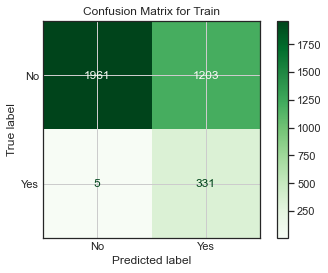

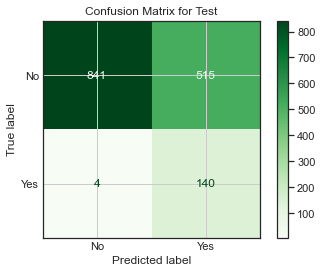

In [65]:
lr = LogisticRegression(solver='newton-cg',random_state=1,fit_intercept=False,class_weight={0:0.15,1:0.85})
model  = lr.fit(X_train_scaled_df,y_train)

statmodel=0 

# checking model performances for the model
scores_Sklearn = get_metrics_score(model,X_train_scaled_df,X_test_scaled_df,y_train,y_test,statmodel)


In [66]:
add_score_model(scores_Sklearn)

**Logistic Regression with Statmodel**

Optimization terminated successfully.
         Current function value: 0.107807
         Iterations 10
 MODEL PERFORMANCE
 Accuracy   : Train: 0.961  Test:  0.955
 Recall     : Train: 0.699  Test: 0.639
 Precision  : Train: 0.87  Test:  0.852
 F1         : Train: 0.776  Test: 0.73


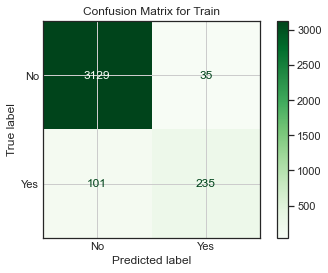

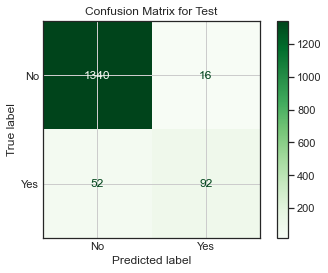

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3484
Method:                           MLE   Df Model:                           15
Date:                Sat, 01 Apr 2023   Pseudo R-squ.:                  0.6591
Time:                        13:12:40   Log-Likelihood:                -377.33
converged:                       True   LL-Null:                       -1106.7
Covariance Type:            nonrobust   LLR p-value:                3.729e-302
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -5.4340      0.247    -21.999      0.000      -5.918      -4.950
Age                            0.2049      0.098      2.083      0.037       0.012       0.398
Income                         3.1304      0.183     17.064      0.000       2.771       3.490
Family                         0.7080      0.109      6.510      0.000       0.495       0.921
CCAvg                          0.1936      0.097      1.991      0.046       0.003       0.384
Mortgage                       0.1049      0.076      1.386      0.166      -0.043       0.253
Securities_Account            -0.3143      0.117     -2.689      0.007      -0.543      -0.085
CD_Account                     0.8979      0.105      8.585      0.000       0.693       1.103
Online                        -0.3449      0.102     -3.393      0.001      -0.544      -0.146
CreditCard                    -0.4773      0.122     -3.921      0.000      -0.716      -0.239
Education_2                    2.0080      0.156     12.907      0.000       1.703       2.313
Education_3                    2.0808      0.158     13.192      0.000       1.772       2.390
Regions_Central               -0.1976      0.118     -1.681      0.093      -0.428       0.033
Regions_Los Angeles Region    -0.0564      0.105     -0.538      0.590      -0.262       0.149
Regions_Southern               0.0321      0.105      0.305      0.761      -0.174       0.239
Regions_Superior              -0.2416      0.183     -1.317      0.188      -0.601       0.118
==============================================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [67]:
# adding constant to training and test set
X_train_stat = sm.add_constant(X_train_scaled_df)
X_test_stat = sm.add_constant(X_test_scaled_df)
statmodel=1  #0 for sklearn and 1 for statmodel
logit = sm.Logit( y_train, X_train_stat.astype(float) )
lg = logit.fit(warn_convergence=False)

# checking model performances for this model
scores_statmodel = get_metrics_score(lg,X_train_stat,X_test_stat,y_train,y_test,statmodel)
lg.summary() 

#### **Test Assumption**

#### MultiCollinearity

**we need check and remove multicollinearity from the data to get reliable coefficients and p-values.**
- am using Variation Inflation Factor(VLF) to test for it in our case.
- NOTE: If VIF is indicate no correlation among the predictor and the other predictor variables whereas if VIF <5 there is high multi-collinearity, the purpose of the analysis is to determine which threshold to use

In [68]:
# changing datatype of colums to numeric for checking vif
X_train_num = X_train_stat.astype(float).copy()

In [69]:
vif_series1 = pd.Series([variance_inflation_factor(X_train_num.values,i) for i in range(X_train_num.shape[1])],index=X_train_num.columns, dtype = float)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                        1.00000
Age                          1.01481
Income                       1.81950
Family                       1.05029
CCAvg                        1.68313
Mortgage                     1.05029
Securities_Account           1.14038
CD_Account                   1.33039
Online                       1.04707
CreditCard                   1.10602
Education_2                  1.25000
Education_3                  1.23914
Regions_Central              1.11837
Regions_Los Angeles Region   1.21651
Regions_Southern             1.23682
Regions_Superior             1.03248
dtype: float64



**Observations:**
There is no correlation between predicator variables since non of the values exceed 5


In [70]:
lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3484
Method:                           MLE   Df Model:                           15
Date:                Sat, 01 Apr 2023   Pseudo R-squ.:                  0.6591
Time:                        13:12:41   Log-Likelihood:                -377.33
converged:                       True   LL-Null:                       -1106.7
Covariance Type:            nonrobust   LLR p-value:                3.729e-302
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -5.4340      0.247    -21.999      0.000      -5.918      -4.950
Age                            0.2049      0.098      2.083      0.037       0.012       0.398
Income                         3.1304      0.183     17.064      0.000       2.771       3.490
Family                         0.7080      0.109      6.510      0.000       0.495       0.921
CCAvg                          0.1936      0.097      1.991      0.046       0.003       0.384
Mortgage                       0.1049      0.076      1.386      0.166      -0.043       0.253
Securities_Account            -0.3143      0.117     -2.689      0.007      -0.543      -0.085
CD_Account                     0.8979      0.105      8.585      0.000       0.693       1.103
Online                        -0.3449      0.102     -3.393      0.001      -0.544      -0.146
CreditCard                    -0.4773      0.122     -3.921      0.000      -0.716      -0.239
Education_2                    2.0080      0.156     12.907      0.000       1.703       2.313
Education_3                    2.0808      0.158     13.192      0.000       1.772       2.390
Regions_Central               -0.1976      0.118     -1.681      0.093      -0.428       0.033
Regions_Los Angeles Region    -0.0564      0.105     -0.538      0.590      -0.262       0.149
Regions_Southern               0.0321      0.105      0.305      0.761      -0.174       0.239
Regions_Superior              -0.2416      0.183     -1.317      0.188      -0.601       0.118
==============================================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

- Since all attributes of Region have a high p-value it means it is not significant therefore we can drop the complete variable.


In [71]:
X_train1 = X_train_stat.drop(["Regions_Central", "Regions_Los Angeles Region", "Regions_Southern", "Regions_Superior",], axis = 1)
X_test1= X_test_stat.drop(["Regions_Central", "Regions_Los Angeles Region", "Regions_Southern", "Regions_Superior",], axis = 1)
logit1 = sm.Logit(y_train, X_train1.astype(float))
lg1 = logit1.fit(warn_convergence =False)

lg1.summary()

Optimization terminated successfully.
         Current function value: 0.108646
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3488
Method:                           MLE   Df Model:                           11
Date:                Sat, 01 Apr 2023   Pseudo R-squ.:                  0.6564
Time:                        13:12:41   Log-Likelihood:                -380.26
converged:                       True   LL-Null:                       -1106.7
Covariance Type:            nonrobust   LLR p-value:                4.623e-305
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.3841      0.243    -22.186      0.000      -5.860      -4.908
Age                    0.2045      0.098      2.089      0.037       0.013       0.396
Income                 3.1097      0.181     17.144      0.000       2.754       3.465
Family                 0.7006      0.108      6.479      0.000       0.489       0.913
CCAvg                  0.1986      0.096      2.058      0.040       0.009       0.388
Mortgage               0.0991      0.075      1.320      0.187      -0.048       0.246
Securities_Account    -0.3036      0.116     -2.609      0.009      -0.532      -0.076
CD_Account             0.9005      0.104      8.659      0.000       0.697       1.104
Online                -0.3596      0.101     -3.548      0.000      -0.558      -0.161
CreditCard            -0.4864      0.121     -4.008      0.000      -0.724      -0.249
Education_2            1.9967      0.155     12.920      0.000       1.694       2.300
Education_3            2.0708      0.157     13.189      0.000       1.763       2.379
======================================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**Pvalue for Mortgage is 0.187 hence we drop it**

In [72]:
 X_train2 = X_train1.drop(['Mortgage'], axis = 1)
 X_test2= X_test1.drop(['Mortgage'], axis = 1)
 logit2 = sm.Logit(y_train, X_train2.astype(float))
 lg2 = logit2.fit()
 lg2.summary()

Optimization terminated successfully.
         Current function value: 0.108894
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3489
Method:                           MLE   Df Model:                           10
Date:                Sat, 01 Apr 2023   Pseudo R-squ.:                  0.6556
Time:                        13:12:41   Log-Likelihood:                -381.13
converged:                       True   LL-Null:                       -1106.7
Covariance Type:            nonrobust   LLR p-value:                8.857e-306
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.3757      0.242    -22.213      0.000      -5.850      -4.901
Age                    0.1988      0.098      2.035      0.042       0.007       0.390
Income                 3.1263      0.181     17.282      0.000       2.772       3.481
Family                 0.7038      0.108      6.508      0.000       0.492       0.916
CCAvg                  0.1871      0.096      1.946      0.052      -0.001       0.375
Securities_Account    -0.3075      0.116     -2.648      0.008      -0.535      -0.080
CD_Account             0.9089      0.104      8.749      0.000       0.705       1.113
Online                -0.3561      0.101     -3.522      0.000      -0.554      -0.158
CreditCard            -0.4887      0.121     -4.035      0.000      -0.726      -0.251
Education_2            1.9877      0.154     12.899      0.000       1.686       2.290
Education_3            2.0648      0.157     13.174      0.000       1.758       2.372
======================================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

- CCavg pvalue is greater than 0.05 but since its a important parameter as per EDA am not going to drop it

 MODEL PERFORMANCE
 Accuracy   : Train: 0.961  Test:  0.957
 Recall     : Train: 0.702  Test: 0.653
 Precision  : Train: 0.861  Test:  0.862
 F1         : Train: 0.774  Test: 0.743


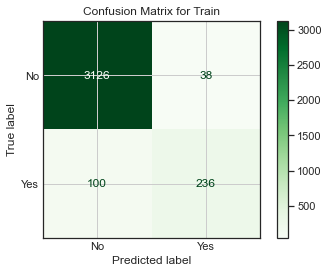

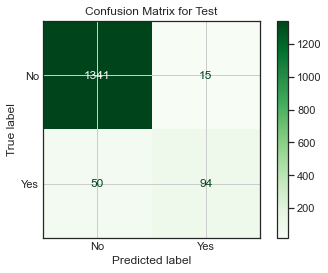

In [73]:
# Let's check model performances for this model

scores_statmodel = get_metrics_score(lg2,X_train2,X_test2,y_train,y_test,statmodel)
add_score_model(scores_statmodel)

#### ROC-AUC curve 


#### Roc -Auc curve on Train data

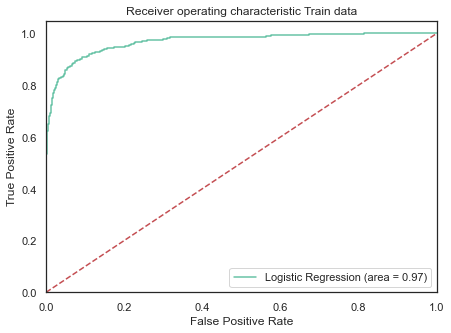

In [74]:
logit_roc_auc_train = roc_auc_score(y_train, lg2.predict(X_train2))
fpr, tpr, thresholds = roc_curve(y_train, lg2.predict(X_train2))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Train data')
plt.legend(loc="lower right")
plt.show()

#### Roc -Auc curve on Test data

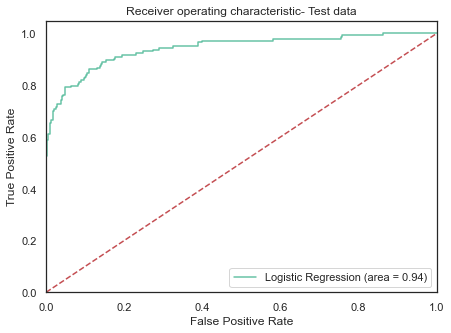

In [75]:
logit_roc_auc_test = roc_auc_score(y_test, lg2.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test, lg2.predict(X_test2))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic- Test data')
plt.legend(loc="lower right")
plt.show()

* Logistic Regression model is giving a generalized performance on training and test set.
* ROC-AUC score of 0.94 on training and test set is quite good.

#### Coefficient interpretations

- Coefficient of  Income, Education, Family,CCavg,CD account,Age,  are positive meaning a one unit  increase in these will lead to increase in chances of a person borrowing loan
- Coefficient of Securities account,online ,Credit card are negative, increase in these will lead to decrease in chances of a person borrowing a loan.

####  Converting coefficients to odds  

- using  odds = exp(b) and will calulate the probability from the odd ratio using probability = odds / (1+odds)
- %age change in odds is odds = (exp(b) - 1) * 100

In [76]:
#Calculate Odds Ratio, probability
##creating a data frame to collate Odds ratio, probability and p-value of the coefficients
lgcoef = pd.DataFrame(lg2.params, columns=['coef'])
lgcoef.loc[:, "Odds Ratio"] = np.exp(lgcoef.coef)
lgcoef['Probability'] = lgcoef['Odds Ratio']/(1+lgcoef['Odds Ratio'])
lgcoef['Percentage Change of Odds']=(np.exp(lg2.params)-1)*100
lgcoef['pval']=lg2.pvalues
pd.options.display.float_format = '{:.2f}'.format
lgcoef = lgcoef.sort_values(by="Odds Ratio", ascending=False)
lgcoef

,coef,Odds Ratio,Probability,Percentage Change of Odds,pval
Income,3.13,22.79,0.96,2179.03,0.00
Education_3,2.06,7.88,0.89,688.39,0.00
Education_2,1.99,7.30,0.88,629.91,0.00
CD_Account,0.91,2.48,0.71,148.17,0.00
Family,0.70,2.02,0.67,102.15,0.00
Age,0.20,1.22,0.55,21.99,0.04
CCAvg,0.19,1.21,0.55,20.57,0.05
Securities_Account,-0.31,0.74,0.42,-26.47,0.01
Online,-0.36,0.70,0.41,-29.96,0.00
CreditCard,-0.49,0.61,0.38,-38.66,0.00


- Income: Holding all other features constant a 1 unit change in Income will increase the odds of a customer taking a personal loan by 22 times 
- Family: Holding all other features constant a 1 unit change in Family will increase the odds of a customer taking a personal loan by 2.02 times increase in the odds of a customer taking personal loan.
- CCAvg: Holding all other features constant a 1 unit change in CCAvg will increase the odds of a customer taking a personal loan by 1.21 times
- Education Advance has  7 times higher chances of taking a personal loan than undergraduate

***Most overall significant varaibles  are Income,Education, CD account ,Family and CCAvg***

### Model performance evaluation and improvement

 MODEL PERFORMANCE
 Accuracy   : Train: 0.961  Test:  0.957
 Recall     : Train: 0.702  Test: 0.653
 Precision  : Train: 0.861  Test:  0.862
 F1         : Train: 0.774  Test: 0.743


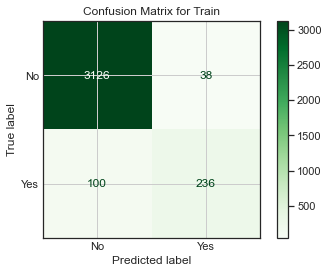

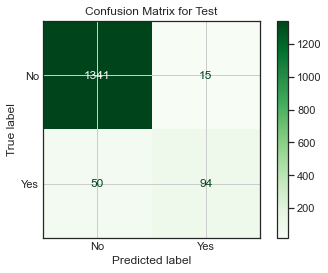

In [77]:
# checking model performances for this model
scores_LR = get_metrics_score(lg2,X_train2,X_test2,y_train,y_test,statmodel)

**Insights:**

**True Positives:**

- Reality: A customer wanted to take personal Loan.
- Model Prediction: The customer will take personal loan.
- Outcome: The model is good.
    
**True Negatives**:

- Reality: A customer didn't wanted to take personal loan.
- Model Prediction: The customer will not take personal loan.
- Outcome: The business is unaffected .

**False Positives** :

- Reality: A customer didn't want to take personal loan.
- Model Prediction: The customer will take personal loan.
- Outcome: The team which is targeting the potential customers would waste their resources on the customers who will not be buying a personal loan.

**False Negatives**:

- Reality: A customer wanted to take personal Loan.
- Model Prediction: The customer will not take personal loan.
- Outcome: The potential customer is missed by the salesteam. This is loss of oppurtunity. The purpose of campaign was to target such customers. If team knew about this customers, they could have offered some good interest rates.

### **Right Metric to use:**
**Basing on the purpose of our prediction here, Recall is the right metric to check the performance of the model .We have it as 70 on train and 65 on test. False negative are 100 and 50 on train and test. We can improve this score  using Optimal threshold for ROC AUC curve and precision recall curve**

#### Optimal threshold using AUC-ROC curve


In [78]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
#fpr, tpr, thresholds = metrics.roc_curve(y_test, lg2.predict(X_test2))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.0847456068057212


 MODEL PERFORMANCE
 Accuracy   : Train: 0.899  Test:  0.887
 Recall     : Train: 0.911  Test: 0.854
 Precision  : Train: 0.486  Test:  0.452
 F1         : Train: 0.634  Test: 0.591


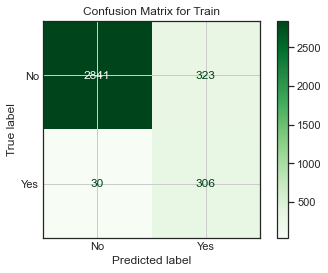

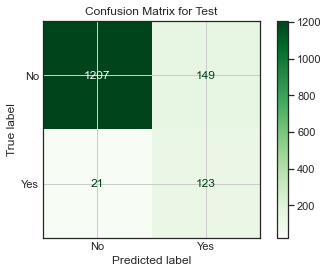

 ROC-AUC Score  :Train::  0.904  Test::  0.872


In [79]:
scores_statmodel = get_metrics_score(lg2,X_train2,X_test2,y_train,y_test,statmodel,threshold=optimal_threshold_auc_roc,roc=True)
add_score_model(scores_statmodel)

With 0.085 Threshold the Recall score has improved with 89% accuracy. 
Also False negative  values has decreased to 21 from 50 for testdata. ROC-AUC score is good too.

##### Let's use Precision-Recall curve and see if we can find a better threshold

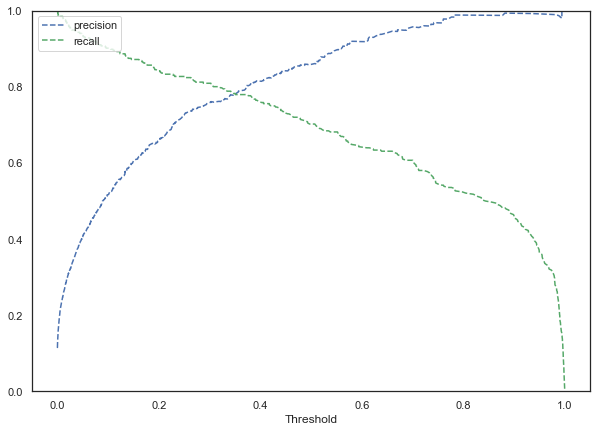

In [80]:
y_scores=lg2.predict(X_train2)
prec, rec, tre = precision_recall_curve(y_train, y_scores,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

 MODEL PERFORMANCE
 Accuracy   : Train: 0.957  Test:  0.942
 Recall     : Train: 0.81  Test: 0.729
 Precision  : Train: 0.76  Test:  0.686
 F1         : Train: 0.784  Test: 0.707


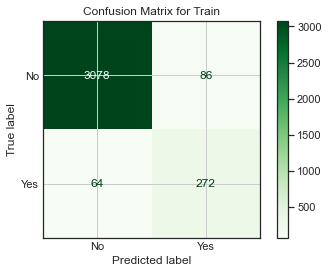

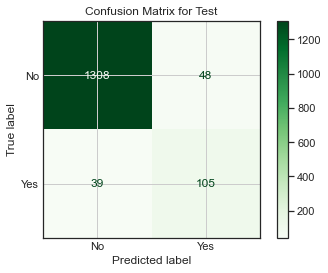

 ROC-AUC Score  :Train::  0.891  Test::  0.847


In [81]:
optimal_threshold_curve = 0.3

scores_opt_curve = get_metrics_score(lg2,X_train2,X_test2,y_train,y_test,statmodel,threshold=optimal_threshold_curve,roc=True)
add_score_model(scores_opt_curve)

- With this model the False negative  cases have gone up and recall for test is 73 with 95 % accuracy.
- Model is performing well on training and test set.
- Model has given a balanced performance, if the bank wishes to maintain a balance between recall and precision this model can be used.
- Area under the curve has decreased as compared to the initial model but the performance is generalized on training and test set.

### Using Sequential Feature Selection


In [82]:
X_train_seq=X_train_stat
X_test_seq=X_test_stat

In [83]:
!pip install mlxtend

In [84]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#from sklearn.lin
X_train_seq.shape

(3500, 16)

In [85]:
statmodel=0 

clf = LogisticRegression(solver='newton-cg',random_state=1,fit_intercept=False)
# for building step forward feature selection
sfs1 = sfs(clf,k_features = 16,forward=True,
           floating=False, scoring= 'recall',
           verbose=2,
           cv=5)

 # Perform SFFS
sfs1 = sfs1.fit(X_train_seq, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.4s finished

[2023-04-01 13:12:56] Features: 1/16 -- score: 0.9940298507462686[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2023-04-01 13:12:57] Features: 2/16 -- score: 0.9970149253731343[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.8s finished

[2023-04-01 13:12:58] Features: 3/16 -- score: 0.9970149253731343[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [86]:
statmodel=0

clf = LogisticRegression(solver='newton-cg',random_state=1,fit_intercept=False)
# Build step forward feature selection
sfs1 = sfs(clf,k_features = 11,forward=True,
           floating=False, scoring= 'recall',
           verbose=2,
           cv=5)

 # Perform SFFS
sfs1 = sfs1.fit(X_train_seq, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.4s finished

[2023-04-01 13:13:06] Features: 1/11 -- score: 0.9940298507462686[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2023-04-01 13:13:07] Features: 2/11 -- score: 0.9970149253731343[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.8s finished

[2023-04-01 13:13:08] Features: 3/11 -- score: 0.9970149253731343[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [87]:
feat_columns = list(sfs1.k_feature_idx_)
print(feat_columns)

[1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]


In [88]:
X_train_seq.columns[feat_columns]

Index(['Age', 'Income', 'CCAvg', 'Mortgage', 'Securities_Account', 'Online',
       'CreditCard', 'Education_2', 'Regions_Central',
       'Regions_Los Angeles Region', 'Regions_Southern'],
      dtype='object')

### fiting a sklearn model using these features only

In [89]:
X_train_final = X_train_seq[X_train_seq.columns[feat_columns]]
X_test_final = X_test_seq[X_train_final.columns]

 MODEL PERFORMANCE
 Accuracy   : Train: 0.679  Test:  0.691
 Recall     : Train: 0.997  Test: 0.972
 Precision  : Train: 0.23  Test:  0.233
 F1         : Train: 0.374  Test: 0.376


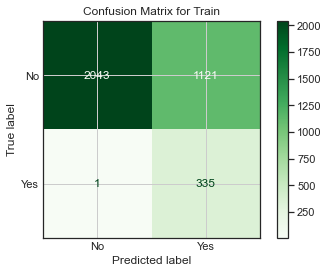

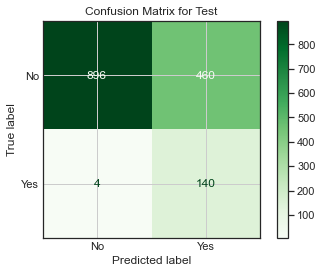

In [90]:
lr = LogisticRegression(solver='newton-cg',random_state=1,fit_intercept=False)
model  = lr.fit(X_train_final,y_train)

statmodel=0  #0 for sklearn and 1 for statmodel

# Let's check model performances for this model
scores_sfs = get_metrics_score(model,X_train_final,X_test_final,y_train,y_test,statmodel)
add_score_model(scores_sfs)

In [91]:
comparison_frame = pd.DataFrame({'Model':['Logistic Regression Model- Sklearn',
                                          'Logistic Regression Model - Statsmodels',
                                          'Logistic Regression - Optimal threshold = 0.085',
                                          'Logistic Regression - Optimal threshold = 0.3',
                                          'Logistic Regression - Sequential feature selection'
                                          ],
                                          'Train_Accuracy':acc_train, 
                                          'Test_Accuracy':acc_test,
                                          'Train Recall':recall_train,
                                          'Test Recall':recall_test, 
                                          'Train Precision':precision_train,
                                          'Test Precision':precision_test,
                                          'Train F1':f1_train,
                                          'Test F1':f1_test
                                })
                                    
    
                                       

comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic Regression Model- Sklearn,0.65,0.65,0.99,0.97,0.22,0.21,0.35,0.35
1,Logistic Regression Model - Statsmodels,0.96,0.96,0.70,0.65,0.86,0.86,0.77,0.74
2,Logistic Regression - Optimal threshold = 0.085,0.90,0.89,0.91,0.85,0.49,0.45,0.63,0.59
3,Logistic Regression - Optimal threshold = 0.3,0.96,0.94,0.81,0.73,0.76,0.69,0.78,0.71
4,Logistic Regression - Sequential feature selection,0.68,0.69,1.00,0.97,0.23,0.23,0.37,0.38


Since we want higher Recall with higher accuracy  Optimal Threshold 0.3 seems to be a good choice. 

# Model building Decision Tree
- Data preparation
- Partition the data into train and test set.
- Built a CART model on the train data.
- Tune the model and prune the tree, if required.
- Test the data on test set.

In [92]:
#drop column not needed for modelling
df_Decision.drop(columns=["Agebin", "ZIPCode","County",'Experience','Income_group','Spending'], inplace=True)

In [93]:
X_dt = df_Decision.drop('Personal_Loan', axis=1)
y_dt = df_Decision['Personal_Loan']

In [94]:
#Cols=['Regions']
Cols=X_dt.select_dtypes(exclude='number').columns.to_list()
X_dt=pd.get_dummies(X_dt,columns=Cols,drop_first=True)
# Spliting data set
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.3, random_state=1, stratify=y_dt)

#### Build Model
- using  'gini' criteria to split. 
- If the frequency of class A is 10% and the frequency of class B is 90%, then class B will become the dominant class and the decision tree will become biased toward the dominant classes.

- To handle this imbalanced data set,we can pass a dictionary {0:0.15,1:0.85} to the model to specify the weight of each class and the decision tree will give more weightage to class 1.

- class_weight is a hyperparameter for the decision tree classifier.
- Since not being able to identify a potential customer is the biggest loss as mentioned  earlier with logistic regression. Hence, recall is the right metric to check the performance of the model.

In [95]:
#  Function to calculate recall score
def get_recall_score(model):
    '''
    model : classifier to predict values of X

    '''
    ytrain_predict = model.predict(X_train_dt)
    ytest_predict = model.predict(X_test_dt)
    # accuracy on training set
    print("\x1b[0;30;47m \033[1mAccuracy : Train :\033[0m", 
          model.score(X_train_dt,y_train_dt),
          "\x1b[0;30;47m \033[1mTest:\033[0m", 
          model.score(X_test_dt,y_test_dt))
# accuracy on training set
    print("\x1b[0;30;47m \033[1mRecall   : Train :\033[0m", 
          metrics.recall_score(y_train_dt,ytrain_predict),
          "\x1b[0;30;47m \033[1mTest:\033[0m", 
          metrics.recall_score(y_test_dt,ytest_predict))
    make_confusion_matrix(y_train_dt,ytrain_predict,"Confusion Matric on Train Data")
    make_confusion_matrix(y_test_dt,ytest_predict,"Confusion Matric on Test Data")

 Accuracy : Train : 1.0  Test: 0.9766666666666667
 Recall   : Train : 1.0  Test: 0.8611111111111112


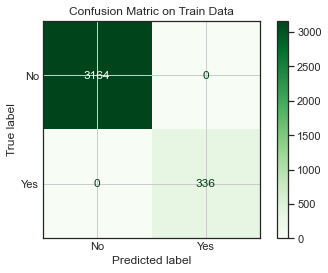

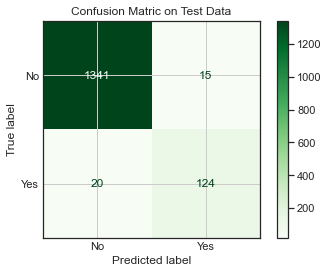

In [96]:
#since data is imbalanced adding weights
model = DecisionTreeClassifier(criterion = 'gini',class_weight={0:0.15,1:0.85}, random_state=1)
model.fit(X_train_dt, y_train_dt)
get_recall_score(model)


Decision tree tends to Overfit and the disparity between the Recall on Train and Test suggest that the model is overfitted


### Visualizing the Decision Tree


In [97]:
column_names = list(X_dt.columns)
feature_names = column_names
print(feature_names)

['Age', 'Income', 'CCAvg', 'Mortgage', 'Family_2', 'Family_3', 'Family_4', 'Education_2', 'Education_3', 'Securities_Account_1', 'CD_Account_1', 'Online_1', 'CreditCard_1', 'Regions_Central', 'Regions_Los Angeles Region', 'Regions_Southern', 'Regions_Superior']


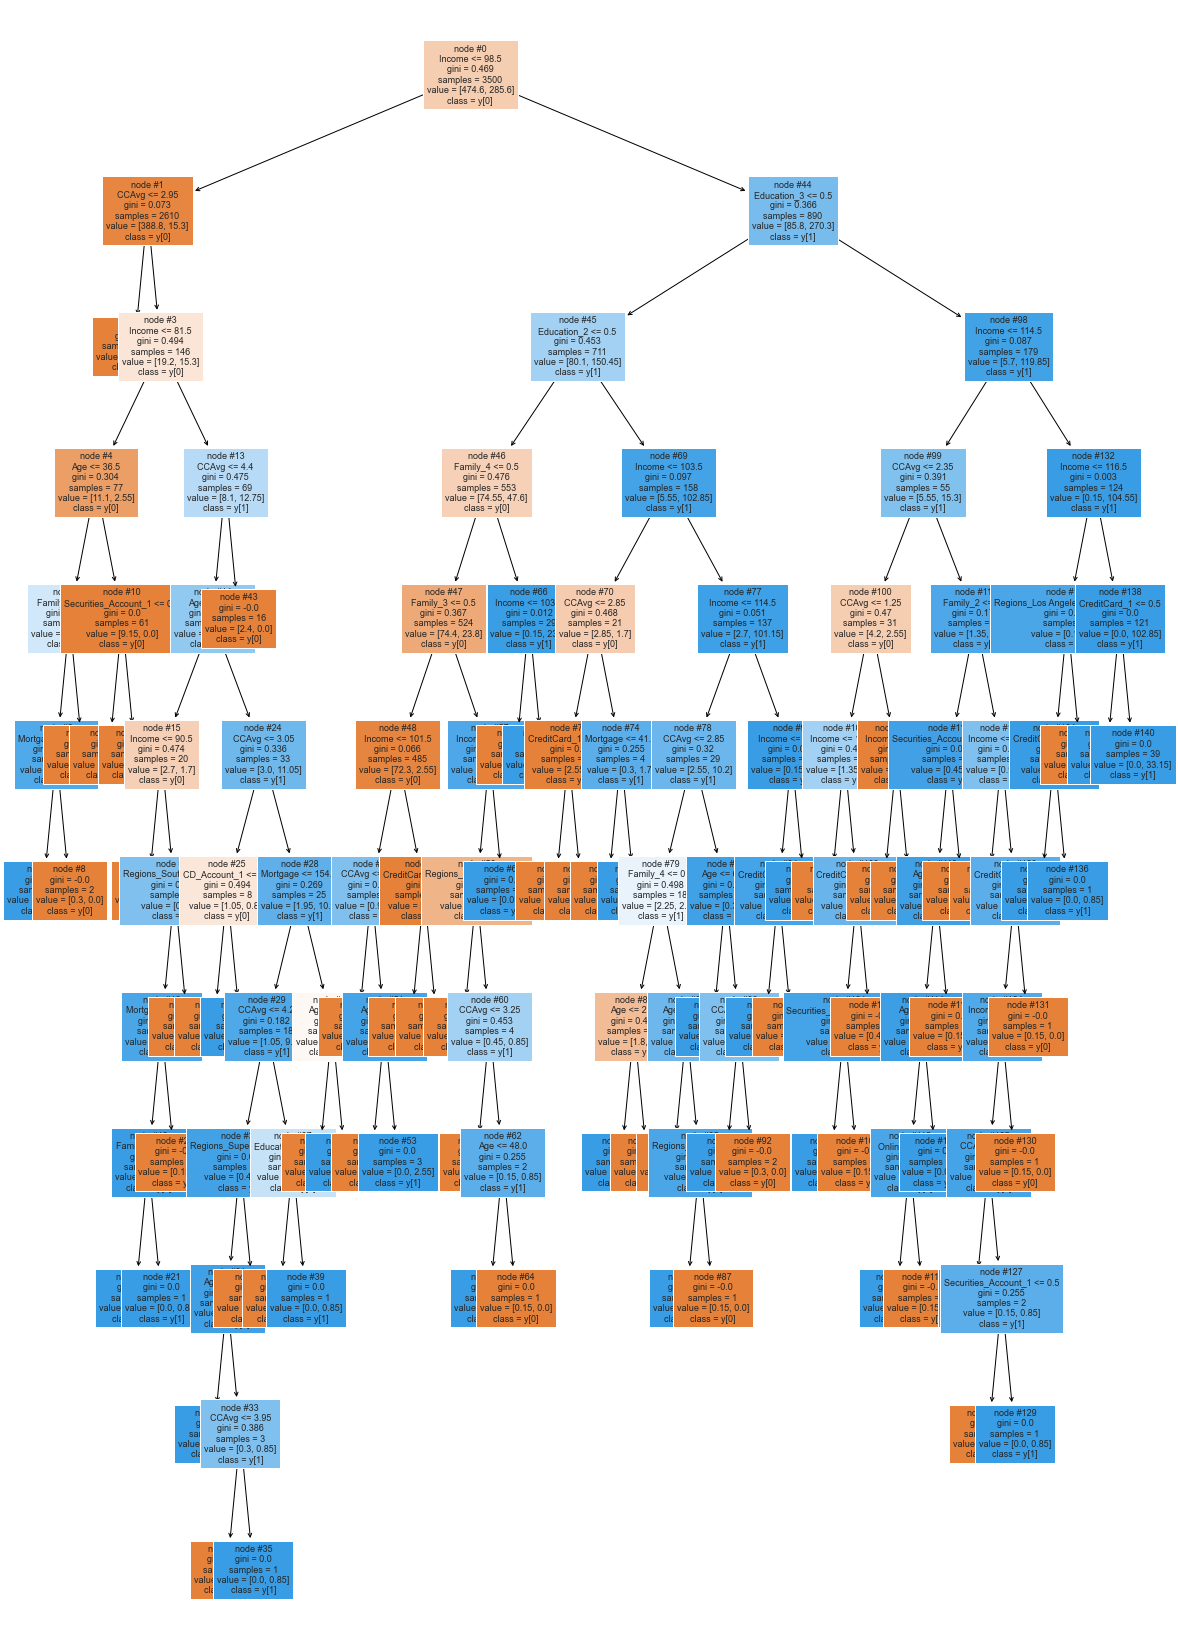

In [98]:
plt.figure(figsize=(20,30))
from sklearn import tree
from sklearn.model_selection import GridSearchCV
out = tree.plot_tree(model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [99]:
# Text report showing the rules of a decision tree -

print(tree.export_text(model,feature_names=feature_names,show_weights=True))

|--- Income <= 98.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [369.60, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 81.50
|   |   |   |--- Age <= 36.50
|   |   |   |   |--- Family_4 <= 0.50
|   |   |   |   |   |--- Mortgage <= 159.50
|   |   |   |   |   |   |--- weights: [0.00, 2.55] class: 1
|   |   |   |   |   |--- Mortgage >  159.50
|   |   |   |   |   |   |--- weights: [0.30, 0.00] class: 0
|   |   |   |   |--- Family_4 >  0.50
|   |   |   |   |   |--- weights: [1.65, 0.00] class: 0
|   |   |   |--- Age >  36.50
|   |   |   |   |--- Securities_Account_1 <= 0.50
|   |   |   |   |   |--- weights: [8.55, 0.00] class: 0
|   |   |   |   |--- Securities_Account_1 >  0.50
|   |   |   |   |   |--- weights: [0.60, 0.00] class: 0
|   |   |--- Income >  81.50
|   |   |   |--- CCAvg <= 4.40
|   |   |   |   |--- Age <= 46.00
|   |   |   |   |   |--- Income <= 90.50
|   |   |   |   |   |   |--- weights: [2.10, 0.00] class: 0
|   |   |   |   |   |--- Income >  90.50
|   |   | 

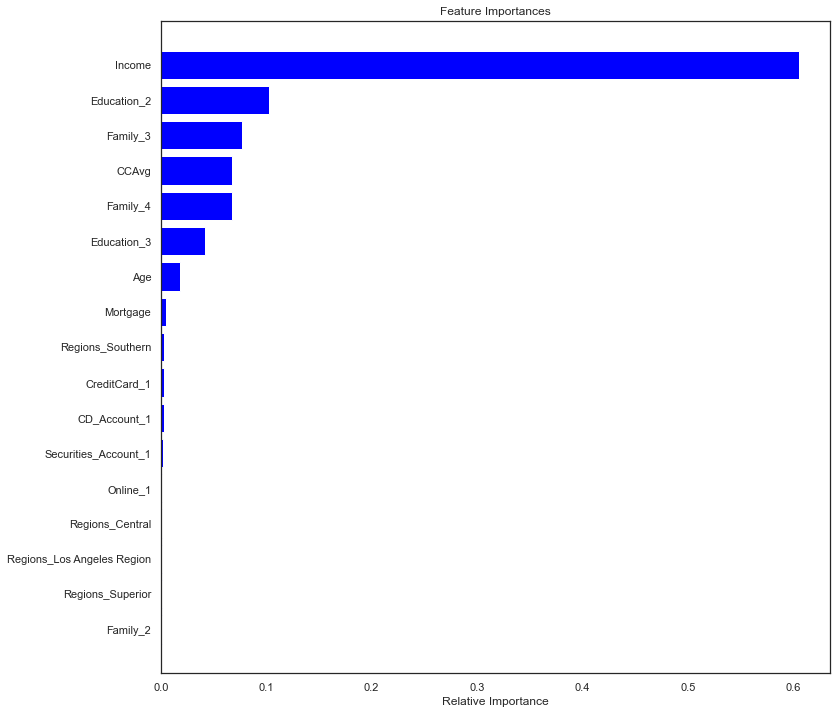

In [100]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [101]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from

parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [5, 10,15,20,25,30],
              }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train_dt, y_train_dt)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_
estimator

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=20, min_samples_leaf=7,
                       random_state=1)

In [102]:
# Fit the best algorithm to the data. 
estimator.fit(X_train_dt, y_train_dt)
ytrain_predict=estimator.predict(X_train_dt)
ytest_predict=estimator.predict(X_test_dt)

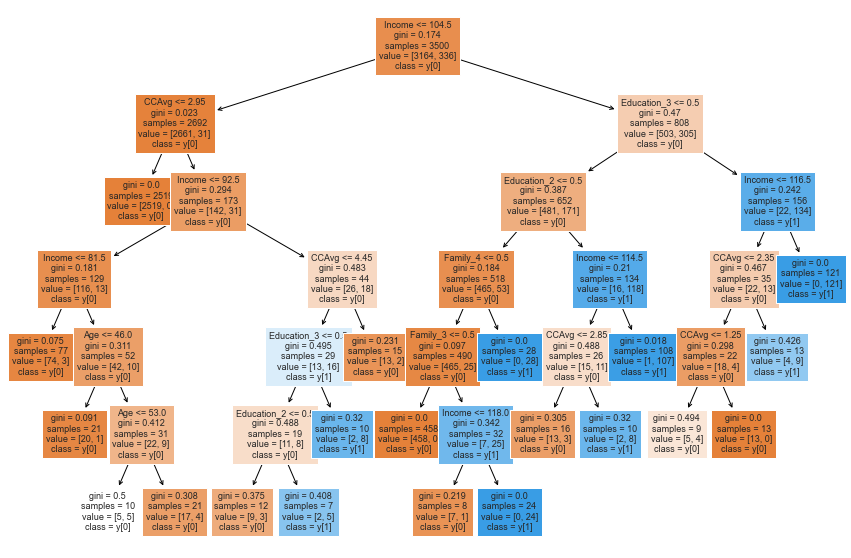

In [103]:
plt.figure(figsize=(15,10))

out = tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

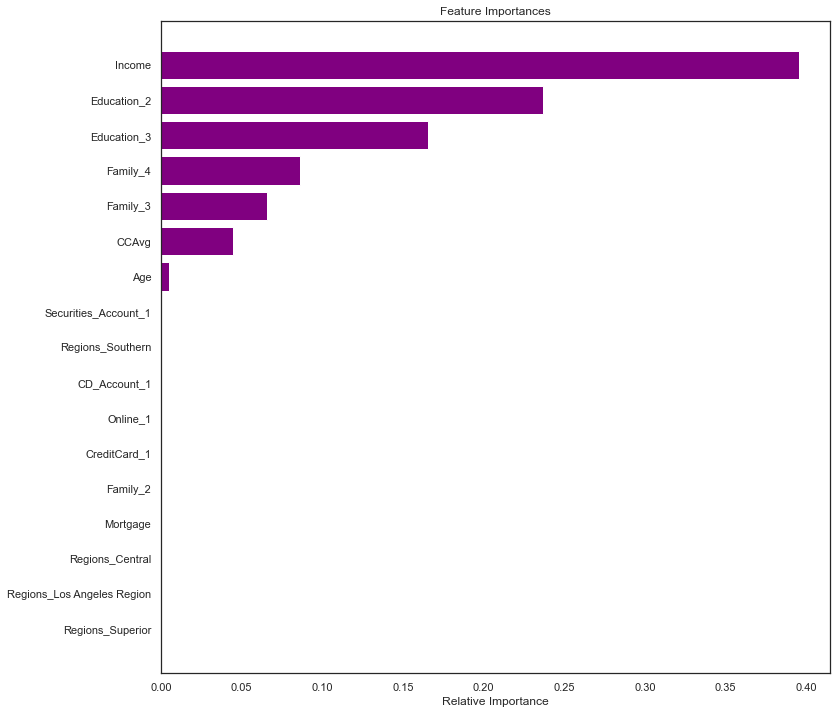

In [104]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

 Accuracy : Train : 0.9894285714285714  Test: 0.978
 Recall   : Train : 0.9226190476190477  Test: 0.8402777777777778


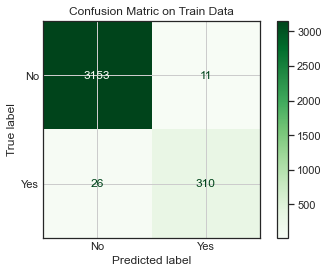

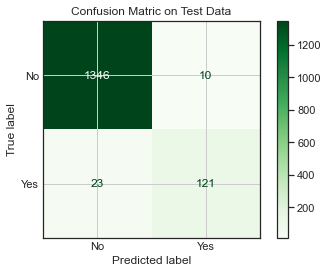

In [105]:
get_recall_score(estimator)

- With HyperParameter max_depth=6, max_leaf_nodes=20, min_samples_leaf=7 the overfitting on  train has reduced, but the recall for test has not improved.
- Important features are Income,Education 2 and Education 3, Family 4, Family 3, CCavg & Age.
- But the recall metric is still 92 and false negatives are 23.  Let see if instead of pre pruning , post pruning helps in reducing false negative.

#### Cost Complexity Pruning


In [106]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train_dt, y_train_dt)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

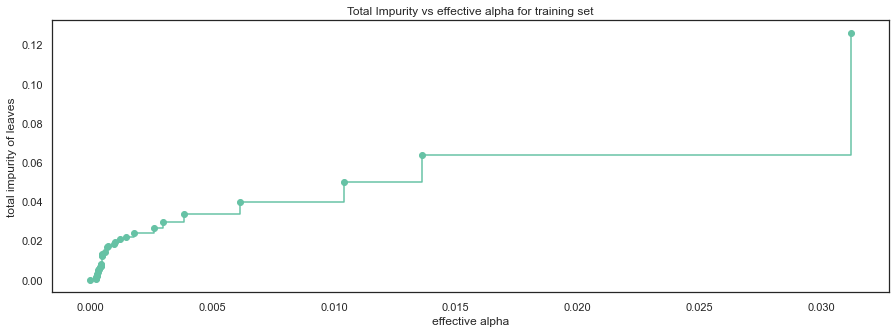

In [107]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

- Training the decision tree using the effective alphas. set values of alpha and pass it to the ccp_alpha parameter of our DecisionTreeClassifier. looping over the alphas array, to find the accuracy on both Train and Test parts of our dataset.


In [108]:
clfs = []
accuracy_train=[]
accuracy_test=[]
recall_train=[]
recall_test=[]
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha,class_weight = {0:0.15,1:0.85})
    clf.fit(X_train_dt, y_train_dt)
    y_train_pred=clf.predict(X_train_dt)
    y_test_pred=clf.predict(X_test_dt)
    accuracy_train.append(clf.score(X_train_dt,y_train_dt))
    accuracy_test.append(clf.score(X_test_dt,y_test_dt))
    recall_train.append(metrics.recall_score(y_train_dt,y_train_pred))
    recall_test.append(metrics.recall_score(y_test_dt,y_test_pred))
    clfs.append(clf)
    


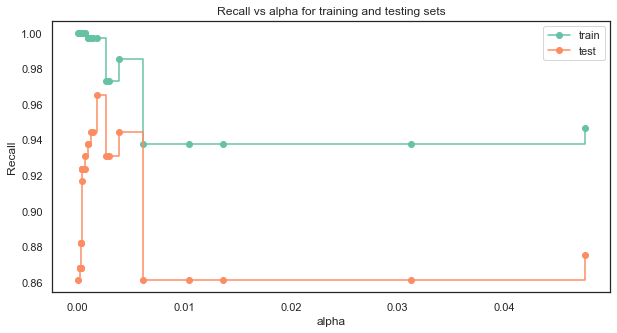

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()
   

We are getting a higher recall on test data between 0.002  to 0.005. choose the low value

#### Creating model with 0.002 ccp_alpha

In [110]:
best_model = DecisionTreeClassifier(ccp_alpha=0.002,
                       class_weight={0: 0.15, 1: 0.85}, random_state=1)
best_model.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(ccp_alpha=0.002, class_weight={0: 0.15, 1: 0.85},
                       random_state=1)

 Accuracy : Train : 0.9768571428571429  Test: 0.9686666666666667
 Recall   : Train : 0.9880952380952381  Test: 0.9583333333333334


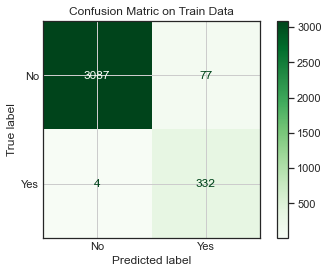

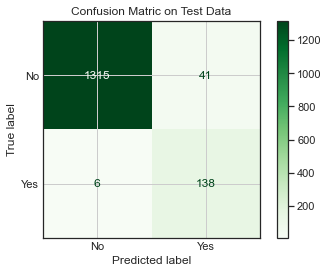

In [111]:
get_recall_score(best_model)


**The Recall on train  and  test indicate we have created a generalized model. with 98 % accuracy and reduced False negatives.**

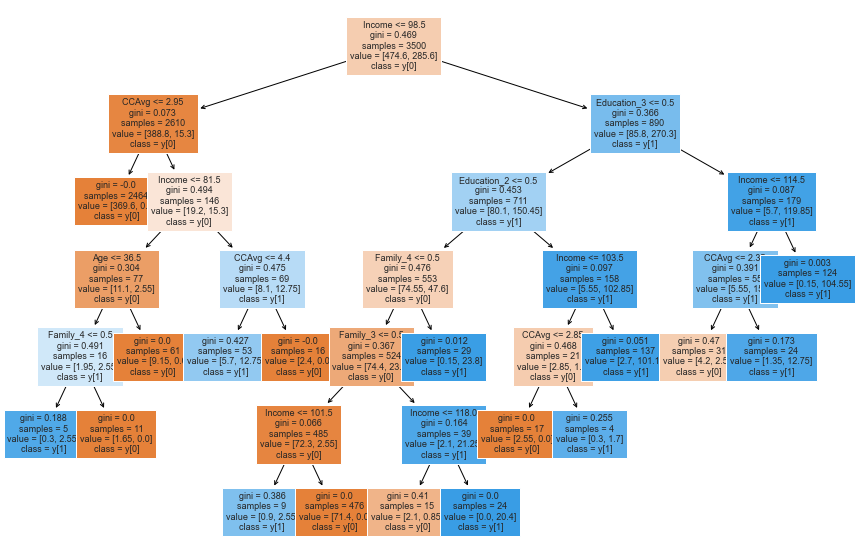

In [112]:
plt.figure(figsize=(15,10))

out = tree.plot_tree(best_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [113]:
# Text report showing the rules of a decision tree -

print(tree.export_text(best_model,feature_names=feature_names,show_weights=True))

|--- Income <= 98.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [369.60, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 81.50
|   |   |   |--- Age <= 36.50
|   |   |   |   |--- Family_4 <= 0.50
|   |   |   |   |   |--- weights: [0.30, 2.55] class: 1
|   |   |   |   |--- Family_4 >  0.50
|   |   |   |   |   |--- weights: [1.65, 0.00] class: 0
|   |   |   |--- Age >  36.50
|   |   |   |   |--- weights: [9.15, 0.00] class: 0
|   |   |--- Income >  81.50
|   |   |   |--- CCAvg <= 4.40
|   |   |   |   |--- weights: [5.70, 12.75] class: 1
|   |   |   |--- CCAvg >  4.40
|   |   |   |   |--- weights: [2.40, 0.00] class: 0
|--- Income >  98.50
|   |--- Education_3 <= 0.50
|   |   |--- Education_2 <= 0.50
|   |   |   |--- Family_4 <= 0.50
|   |   |   |   |--- Family_3 <= 0.50
|   |   |   |   |   |--- Income <= 101.50
|   |   |   |   |   |   |--- weights: [0.90, 2.55] class: 1
|   |   |   |   |   |--- Income >  101.50
|   |   |   |   |   |   |--- weights: [71.40, 0.00] class: 0
| 

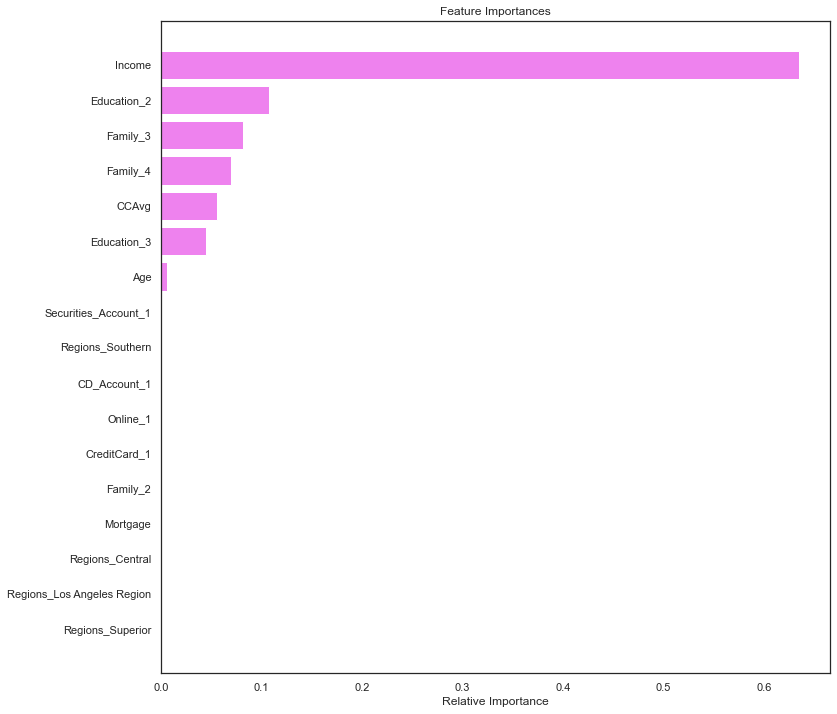

In [114]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- We are getting  a higher recall on test data between 0.002  to 0.005. Will choosed alpha as 0.002.
- The Recall on train  and  test indicate we have created a generalized model. with 98 % accuracy and reduced False  negatives.
- Important features : Income, Graduate education, Family member  3 and 4, Ccavg, Advanced education, Age.
- This is the best model since it has the least number of false negative in Testdata.


### Comparing all the models based on Model Performance

In [115]:
comparison_frame = pd.DataFrame({'Model':['Logisitic Regression with Optimal Threshold 0.104',
                                          'Initial decision tree model',
                                          'Decision treee with hyperparameter tuning',
                                          'Decision tree with post-pruning'], 
                                          'Train_accuracy':[0.92,1,0.99,0.98],
                                          'Test_accuracy':[0.91,0.98,0.98,0.97],
                                          'Train_Recall':[0.90,1,0.92,0.98], 
                                          'Test_Recall':[0.88,0.86,0.84,0.96]})  

comparison_frame

,Model,Train_accuracy,Test_accuracy,Train_Recall,Test_Recall
0,Logisitic Regression with Optimal Threshold 0.104,0.92,0.91,0.90,0.88
1,Initial decision tree model,1.00,0.98,1.00,0.86
2,Decision treee with hyperparameter tuning,0.99,0.98,0.92,0.84
3,Decision tree with post-pruning,0.98,0.97,0.98,0.96


- Decision tree model post pruning gives the best recall scores on data with 98% accuracy . Exploratory data analysis  also suggested income and education were important features in deciding if person will borrow personal loan.
- so choosing  Decision Tree with post-pruning for our prediction is the best choice.

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1356
           1       0.77      0.96      0.85       144

    accuracy                           0.97      1500
   macro avg       0.88      0.96      0.92      1500
weighted avg       0.97      0.97      0.97      1500



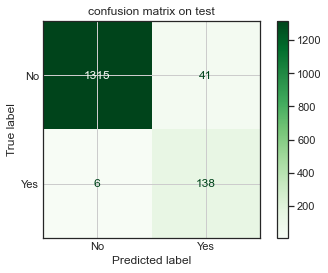

In [116]:
y_pred = best_model.predict(X_test_dt)
print(classification_report(y_test_dt,y_pred))
make_confusion_matrix(y_test,y_pred,"confusion matrix on test")

**Observation**

- After Post Pruning ,the false negative has reduced to 6.The accuracy on test data is 97% & Recall is 97% after choosing optimal cc-alpha. 


# Actionable Insights & Recommendations

### Misclassification Analysis


In [117]:
misclass_df = X_test_dt.copy()

In [118]:
misclass_df['Actual']=y_test_dt
misclass_df['Predicted'] = y_pred


([<matplotlib.patches.Wedge at 0x29024e7eeb0>,
 [Text(-1.050350983068654, 0.3267457916587637, ''),
  Text(1.0503509677725784, -0.32674584082924163, '')],
 [Text(-0.5729187180374475, 0.17822497726841657, '90.4%'),
  Text(0.5729187096941336, -0.17822500408867725, '9.6%')])

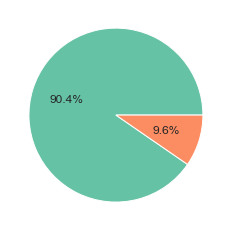

In [119]:
plt.pie(data=misclass_df,x=misclass_df["Actual"].value_counts(),autopct='%1.1f%%')


([<matplotlib.patches.Wedge at 0x29024e4d760>,
 [Text(-1.023599997039702, 0.40279404918682976, ''),
  Text(1.0236000064677768, -0.40279402522774294, '')],
 [Text(-0.5583272711125646, 0.21970584501099802, '88.1%'),
  Text(0.5583272762551509, -0.2197058319424052, '11.9%')])

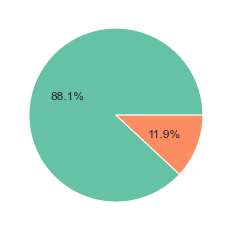

In [120]:
plt.pie(data=misclass_df,x=misclass_df["Predicted"].value_counts(),autopct='%1.1f%%')

Percentage of value predicted by our model is very close to the actual values. need to find out False Negative and False Positive observations

In [121]:
pd.crosstab(misclass_df['Predicted'],misclass_df['Actual'],margins=True)

Actual,0,1,All
Predicted,,,
0,1315,6,1321
1,41,138,179
All,1356,144,1500


<AxesSubplot:xlabel='Predicted'>

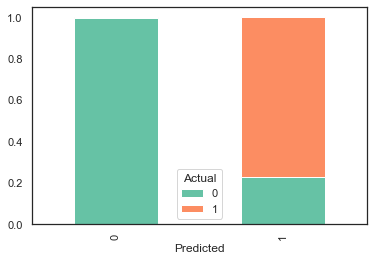

In [122]:
pd.crosstab(misclass_df['Predicted'],misclass_df['Actual'],normalize='index').plot(kind='bar',stacked=True)

In [123]:
# Rows that were classified as Negative when they were actually positive
fn_rows = misclass_df[(misclass_df['Actual'] == 1) & (misclass_df['Predicted'] == 0)]


In [124]:
False_negative= df_Decision[df_Decision.index.isin(fn_rows.index.values)].copy()
False_negative

,Age,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Regions
1069,44,75,2,3.50,1,0,1,0,0,1,0,Los Angeles Region
1126,32,104,2,3.70,1,0,1,0,0,0,1,Bay Area
1518,43,64,4,3.00,3,221,1,0,0,1,0,Bay Area
2361,36,109,3,0.50,3,0,1,1,1,1,0,Bay Area
2623,42,111,3,3.00,1,0,1,1,1,0,1,Bay Area
2996,42,103,1,3.33,1,0,1,1,1,1,1,Los Angeles Region


- Our model predicted some customers wrongly. On analyzing the Income , Education,Family , we can see the income is not in range of High income group and education is undergrad for most of them and there average spending is also low.

In [125]:
# Rows put as postive when they were actually negative
fp_rows = misclass_df[(misclass_df['Actual'] == 0) & (misclass_df['Predicted'] == 1)]
fp_rows
False_Positive= df_Decision[df_Decision.index.isin(fp_rows.index.values)].copy()
False_Positive

,Age,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Regions
10,65,105,4,2.40,3,0,0,0,0,0,0,Bay Area
82,41,82,1,4.00,3,0,0,0,0,1,0,Southern
185,39,115,1,1.00,3,0,0,0,0,1,0,Southern
553,52,101,2,0.30,1,0,0,0,0,0,0,Los Angeles Region
585,34,83,4,4.00,3,0,0,0,0,1,0,Southern
697,42,85,1,3.70,3,0,0,0,0,1,0,Southern
746,62,85,4,3.40,2,0,0,0,0,1,0,Bay Area
792,41,98,1,4.00,3,0,0,0,0,0,1,Southern
916,44,85,2,3.20,1,0,0,0,0,1,0,Southern
1045,43,84,1,4.00,3,0,0,0,0,0,0,Southern


- most customers have  education as Advance or Graduate . These cases are some exceptions.



## <span style="color:blue">Conclusion</span>

- I analyzed the "Potential Loan marketing data" using different techniques and used a Decision Tree Classifier to build a predictive model. The predictive model helps predict whether a liability customer will buy a personal loan or not.
- Income, education, family, and credit card usage are the most important features in predicting potential loan customers.
- Those customers with separate securities and cd accounts are more likely to get a personal loan. Customers who use the bank's online facilities are more likely to get a personal loan versus those customers who don't use the online facilities.
- We established the importance of hyper-parameters/pruning to reduce overfitting during the model selection process.

## <span style="color:blue">Recommendations</span>
- Decision tree model shows income has the most important feature. If our customer's yearly income is less than 98.5K, there is a good chance the customer will not have a personal loan. 
- From the model, we also see that those customers with an income greater than 98.5 and with an education level greater than or equal to 3 Advanced/Professional were most likely to have a personal loan. Recommend to target customers that have incomes lower than 98K.
- we observed that those customers who use the online facilities were more likely to have personal loans. Make the site more user-friendly and encourage those customers who don't use the facilities to use the online facilities. Make the application process to get personal loans easy with a better user friendly experience.this will help